# PulseTrackz
## Spin Class Playlist ML Model

![banner image](https://metpro.co/wp-content/uploads/2023/03/AdobeStock_406831633-scaled.jpeg)

## Scenario

Fitness instructors and enthusiasts alike face a recurring challenge: creating the perfect playlist for spin classes that aligns with workout phases like warm-up, sprint, climb, interval, and cool-down. Manually curating these playlists is time-consuming, subjective, and often lacks the precision to match the energy dynamics of a class. Platforms like Spotify offer massive music libraries, but not tools tailored for exercise-specific curation. Popular apps like Peloton offer energetic classes, but don’t give users the ability to customize their classes around their own unique music tastes. PulseTrackz addresses these gaps by automatically generating spin-class playlists that are optimized for workout flow using machine learning classification.

## Data Import

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from collections import Counter, defaultdict
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import label_binarize


In [2]:
# Load data
df = pd.read_csv('train.csv')

# Show basic info and summary
print("\nDataFrame Shape:")
print(df.shape)

print("\nDataFrame Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nSummary stats:")
print(df.describe())



DataFrame Shape:
(114000, 21)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  11

## Data Exploration

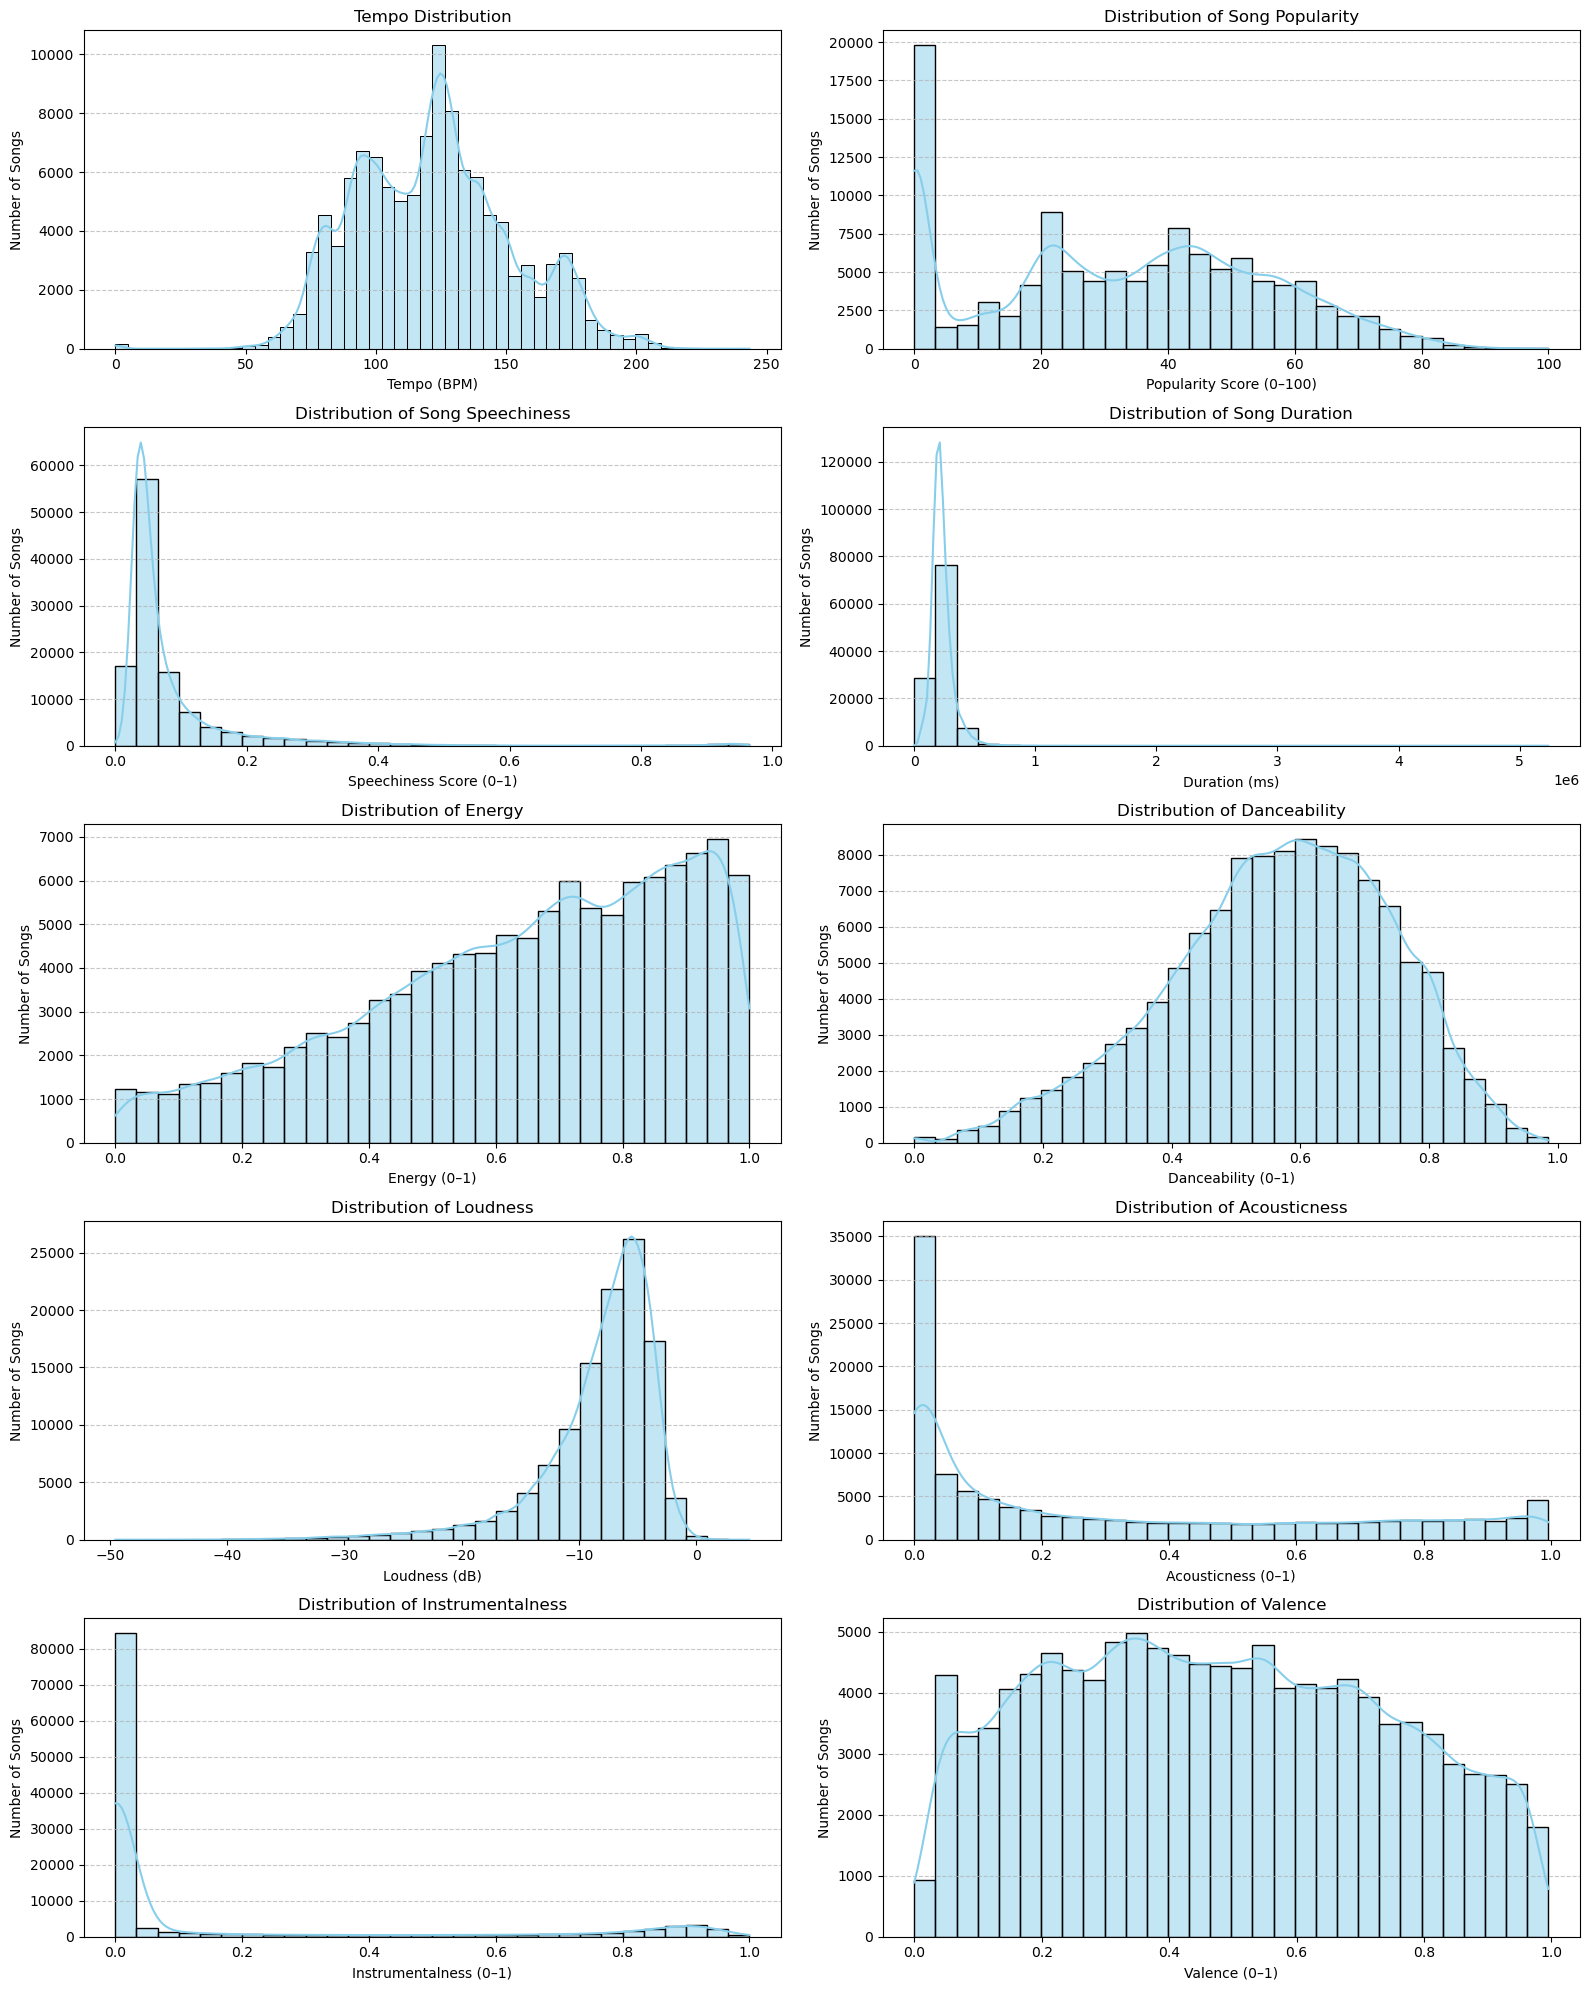

In [3]:
# Plot key quantitative features
def plot_hist(ax, data, column, title, xlabel, bins=30, color='skyblue'):
    sns.histplot(data[column], bins=bins, kde=True, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create 5x2 grid
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

# Define plots
plot_configs = [
    ('tempo', 'Tempo Distribution', 'Tempo (BPM)', 50),
    ('popularity', 'Distribution of Song Popularity', 'Popularity Score (0–100)', 30),
    ('speechiness', 'Distribution of Song Speechiness', 'Speechiness Score (0–1)', 30),
    ('duration_ms', 'Distribution of Song Duration', 'Duration (ms)', 30),
    ('energy', 'Distribution of Energy', 'Energy (0–1)', 30),
    ('danceability', 'Distribution of Danceability', 'Danceability (0–1)', 30),
    ('loudness', 'Distribution of Loudness', 'Loudness (dB)', 30),
    ('acousticness', 'Distribution of Acousticness', 'Acousticness (0–1)', 30),
    ('instrumentalness', 'Distribution of Instrumentalness', 'Instrumentalness (0–1)', 30),
    ('valence', 'Distribution of Valence', 'Valence (0–1)', 30),
]

# Plot all charts
for ax, (col, title, xlabel, bins) in zip(axes, plot_configs):
    plot_hist(ax, df, col, title, xlabel, bins=bins)

# Layout
plt.tight_layout()
plt.show()


In [4]:
# Convert duration_ms to MM:SS format
df['duration_MM_SS'] = df['duration_ms'].apply(lambda x: f"{int(x // 60000):02}:{int((x % 60000) // 1000):02}")

df['duration_MM_SS'].head()

0    03:50
1    02:29
2    03:30
3    03:21
4    03:18
Name: duration_MM_SS, dtype: object

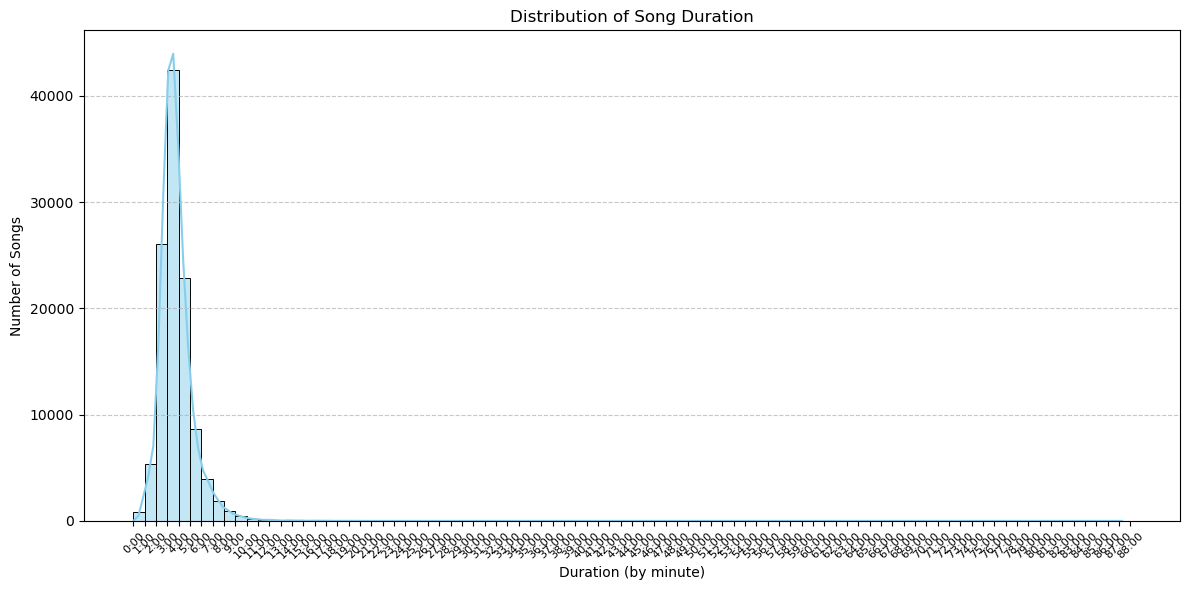

In [5]:
# Distribution of Duration
# Convert duration_ms to seconds
df['duration_sec'] = df['duration_ms'] // 1000

# Create bins of 30-second intervals
bin_width = 60
max_duration = df['duration_sec'].max()
bins = range(0, int(max_duration + bin_width), bin_width)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(df['duration_sec'], bins=bins, kde=True, color='skyblue')

plt.title('Distribution of Song Duration')
plt.xlabel('Duration (by minute)')
plt.ylabel('Number of Songs')
plt.xticks(ticks=bins, labels=[f"{int(b//60)}:{int(b%60):02}" for b in bins], rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

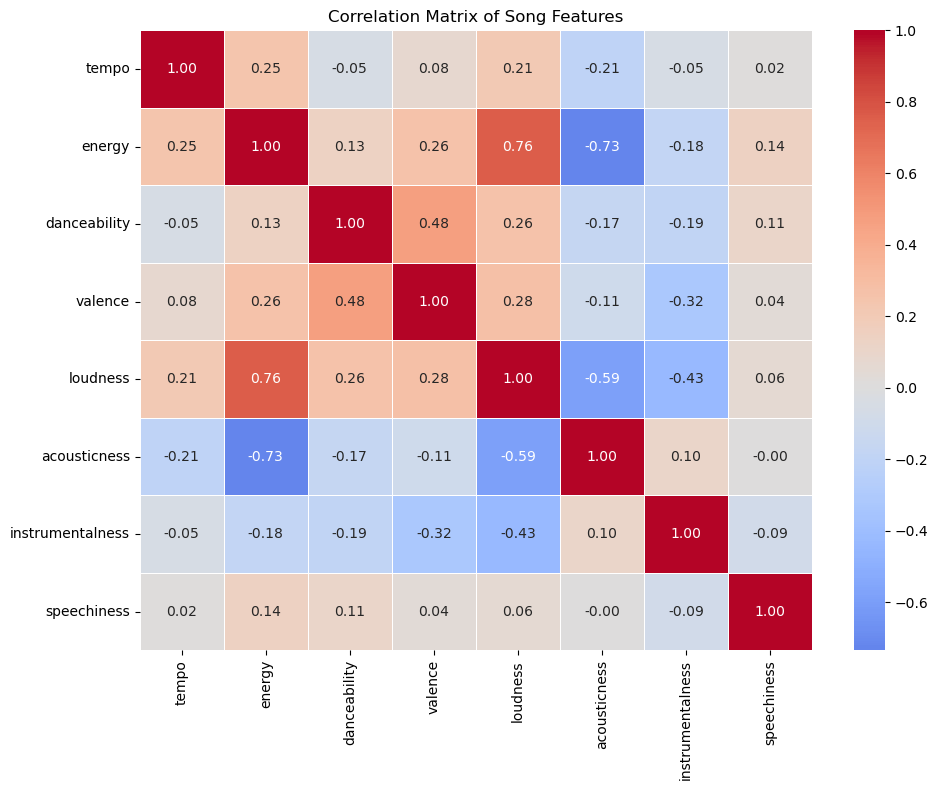

In [6]:
# Correlation Matrix
numeric_features = ['tempo', 'energy', 'danceability', 'valence', 'loudness',
                    'acousticness', 'instrumentalness', 'speechiness']

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Song Features')
plt.tight_layout()
plt.show()


In [7]:
# Top Artists
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply parser
artist_lists = df['artists'].dropna().apply(parse_artists)

# Flatten and count
flat_artists = [artist for sublist in artist_lists for artist in sublist]
artist_counts = Counter(flat_artists)
top_artists = artist_counts.most_common(10)

# Display results
print("Top 10 Most Common Artists:")
for i, (artist, count) in enumerate(top_artists, 1):
    print(f"{i}. {artist}: {count} songs")


Top 10 Most Common Artists:
1. J Balvin: 510 songs
2. Bad Bunny: 416 songs
3. Daddy Yankee: 375 songs
4. Wolfgang Amadeus Mozart: 354 songs
5. Feid: 348 songs
6. George Jones: 343 songs
7. Pritam: 333 songs
8. Arijit Singh: 305 songs
9. ILLENIUM: 298 songs
10. The Beatles: 280 songs


In [8]:
# Check numeric features by artists
# Parse artists using the current format
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply 
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)
df_exploded = df_copy.explode('artists_list')

# Filter to top 10 artists
top_10_names = [artist for artist, _ in top_artists]
filtered = df_exploded[df_exploded['artists_list'].isin(top_10_names)]

# Group and summarize by tempo, energy, and danceability
artist_stats = filtered.groupby('artists_list')[['tempo', 'energy', 'danceability']].mean().sort_values(by='tempo', ascending=False)

# Display
print("Average Tempo, Energy, and Danceability for Top 10 Artists:")
print(artist_stats)


Average Tempo, Energy, and Danceability for Top 10 Artists:
                              tempo    energy  danceability
artists_list                                               
Feid                     139.236848  0.637839      0.764468
ILLENIUM                 139.161634  0.720721      0.468138
The Beatles              122.552939  0.540763      0.519114
J Balvin                 122.339737  0.738053      0.767957
Arijit Singh             116.177407  0.592059      0.530426
Pritam                   114.321586  0.711018      0.593760
Daddy Yankee             112.968816  0.835701      0.754843
Wolfgang Amadeus Mozart  111.036588  0.121095      0.411643
Bad Bunny                110.918115  0.691075      0.760397
George Jones             109.318924  0.357306      0.538583


In [9]:
# Top Artist by Genre
# Parse artists into lists
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)

# Explode artists to get one row per artist-track
df_exploded = df_copy.explode('artists_list')

# Group by genre and artist, then count
genre_artist_counts = df_exploded.groupby(['track_genre', 'artists_list']).size().reset_index(name='count')

# For each genre, get top artist(s)
top_artists_by_genre = (
    genre_artist_counts
    .sort_values(['track_genre', 'count'], ascending=[True, False])
    .groupby('track_genre')
    .head(1)
)

# Display
pd.set_option('display.max_rows', None) 
print("Top Artist by Genre:")
display(top_artists_by_genre)


Top Artist by Genre:


,track_genre,artists_list,count
52,acoustic,Boyce Avenue,45
409,afrobeat,Criolo,73
979,alt-rock,Red Hot Chili Peppers,38
1178,alternative,GAYLE,41
1651,ambient,Ludovico Einaudi,69
1950,anime,Kato,56
2280,black-metal,Hypocrisy,29
2525,bluegrass,Greensky Bluegrass,56
2799,blues,Ella Fitzgerald,131
3355,brazil,Maneva,31


## Feature Engineering

In [10]:
# Create new 'spin genre' feature
spin_genre_map = {
    # Pop/EDM/Electronic
    'pop': 'pop/edm',
    'dance': 'pop/edm',
    'edm': 'pop/edm',
    'club': 'pop/edm',
    'house': 'pop/edm',
    'deep-house': 'pop/edm',
    'electro': 'pop/edm',
    'electronic': 'pop/edm',
    'progressive-house': 'pop/edm',
    'synth-pop': 'pop/edm',
    'trance': 'pop/edm',
    'disco': 'pop/edm',
    'party': 'pop/edm',
    'techno': 'pop/edm',
    'garage': 'pop/edm',
    'detroit-techno': 'pop/edm',
    'minimal-techno': 'pop/edm',
    'breakbeat': 'pop/edm',
    'drum-and-bass': 'pop/edm',
    'dubstep': 'pop/edm',
    'trip-hop': 'pop/edm',
    'idm': 'pop/edm',
    'british': 'pop/edm',
    'chicago-house': 'pop/edm',
    'dub': 'pop/edm',
    'garage': 'pop/edm',

    # Rock/Alternative
    'rock': 'rock/alt',
    'alt-rock': 'rock/alt',
    'alternative': 'rock/alt',
    'indie': 'rock/alt',
    'indie-pop': 'rock/alt',
    'punk': 'rock/alt',
    'punk-rock': 'rock/alt',
    'psych-rock': 'rock/alt',
    'grunge': 'rock/alt',
    'goth': 'rock/alt',
    'emo': 'rock/alt',
    'hard-rock': 'rock/alt',
    'hardcore': 'rock/alt',
    'metal': 'rock/alt',
    'heavy-metal': 'rock/alt',
    'death-metal': 'rock/alt',
    'metalcore': 'rock/alt',
    'grindcore': 'rock/alt',
    'rock-n-roll': 'rock/alt',
    'rockabilly': 'rock/alt',

    # Hip-Hop/Rap
    'hip-hop': 'hip hop',
    'rap': 'hip hop',

    # R&B/Soul/Funk
    'r-n-b': 'r&b/soul',
    'soul': 'r&b/soul',
    'funk': 'r&b/soul',
    'gospel': 'r&b/soul',
    'groove': 'r&b/soul',

    # Singer-Songwriter/Folk/Acoustic
    'acoustic': 'acoustic/folk',
    'folk': 'acoustic/folk',
    'bluegrass': 'acoustic/folk',
    'singer-songwriter': 'acoustic/folk',
    'songwriter': 'acoustic/folk',
    'country': 'acoustic/folk',
    'americana': 'acoustic/folk',
    'honky-tonk': 'acoustic/folk',

    # Latin/World
    'latin': 'latin',
    'latino': 'latin',
    'reggaeton': 'latin',
    'salsa': 'latin',
    'samba': 'latin',
    'mpb': 'latin',
    'forro': 'latin',
    'pagode': 'latin',
    'brazil': 'latin',
    'spanish': 'latin',

    # Easy Listening
    'ambient': 'easy-listening',
    'chill': 'easy-listening',
    'study': 'easy-listening',
    'sleep': 'easy-listening',
    'piano': 'easy-listening',
    'new-age': 'easy-listening',
    'opera': 'easy-listening',
    'classical': 'easy-listening',
    'jazz': 'easy-listening',

    # International/Language-specific
    'anime': 'intl/other',
    'cantopop': 'intl/other',
    'mandopop': 'intl/other',
    'j-pop': 'intl/other',
    'j-rock': 'intl/other',
    'j-dance': 'intl/other',
    'j-idol': 'intl/other',
    'k-pop': 'intl/other',
    'french': 'intl/other',
    'german': 'intl/other',
    'iranian': 'intl/other',
    'malay': 'intl/other',
    'turkish': 'intl/other',
    'indian': 'intl/other',
    'swedish': 'intl/other',
    'world-music': 'intl/other',

    # Sing-Along
    'disney': 'sing-along',
    'show-tunes': 'sing-along',

    # Non-Workout
    'children': 'non-workout',
    'comedy': 'non-workout',
    'romance': 'non-workout',
    'happy': 'non-workout',
    'sad': 'non-workout',
    'kids': 'non-workout',
    'ambient': 'non-workout',
    'sleep': 'non-workout',
    'comedy': 'non-workout'
}

df['spin_genre'] = df['track_genre'].map(spin_genre_map).fillna('other')

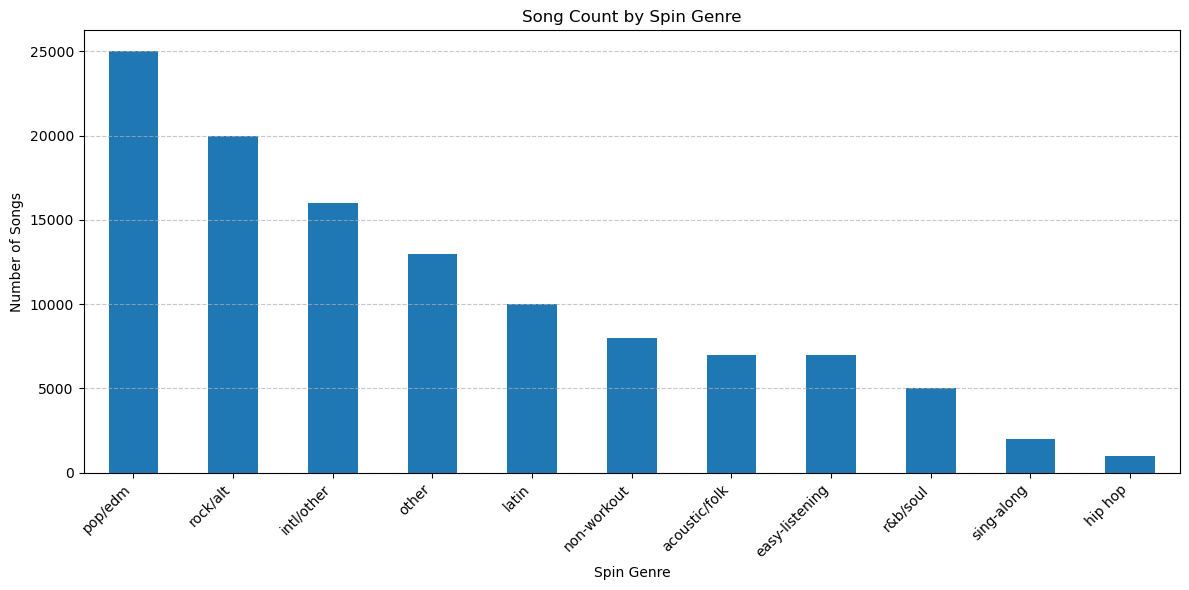

In [11]:
# Count number of songs per spin genre
genre_counts = df['spin_genre'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Spin Genre')
plt.xlabel('Spin Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


These ratios are being created for the following reasons:
- Tempo:Energy | Adds nuance to how songs feel energetically across tempo bands and is especially useful in teasing apart interval, sprint, and warm up.
- Energy:Danceability | Captures how intensely energetic a track is relative to how rhythmically fluid or danceable it is.
- Energy:Loudness | Captures relative “punch” or intensity per decibel. Could help distinguish interval from sprint or climb.
- Valence: Danceability | Valence is more emotional; danceability is more rhythmic. A high ratio could flag “happy but undanceable” songs — useful for warm up or non-workout.
- Energy:Acousticness | Inversely correlated. A high value means highly energetic & non-acoustic (think club/dance), great for sprint detection.
- Loudness: Instrumentalness | High loudness but low instrumentalness could flag vocals-heavy intense songs — separating sprint or climb from ambient/cooldown tracks.

In [12]:
# Create tempo:energy ratio
df['tempo_energy_ratio'] = df['tempo'] / (df['energy'] + 1e-5)

# Create energy:danceability ratio
df['energy_danceability_ratio'] = df['energy'] / (df['danceability'] + 1e-5)

# Energy:loudness ratio
df['energy_loudness_ratio'] = df['energy'] / (df['loudness'] + 1e-5)

# Valence:danceability ratio
df['valence_danceability_ratio'] = df['valence'] / (df['danceability'] + 1e-5)

# Energy:acousticness ratio
df['energy_acousticness_ratio'] = df['energy'] / (df['acousticness'] + 1e-5)

# Loudness:instrumentalness ratio
df['loudness_instrumentalness_ratio'] = df['loudness'] / (df['instrumentalness'] + 1e-5)


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


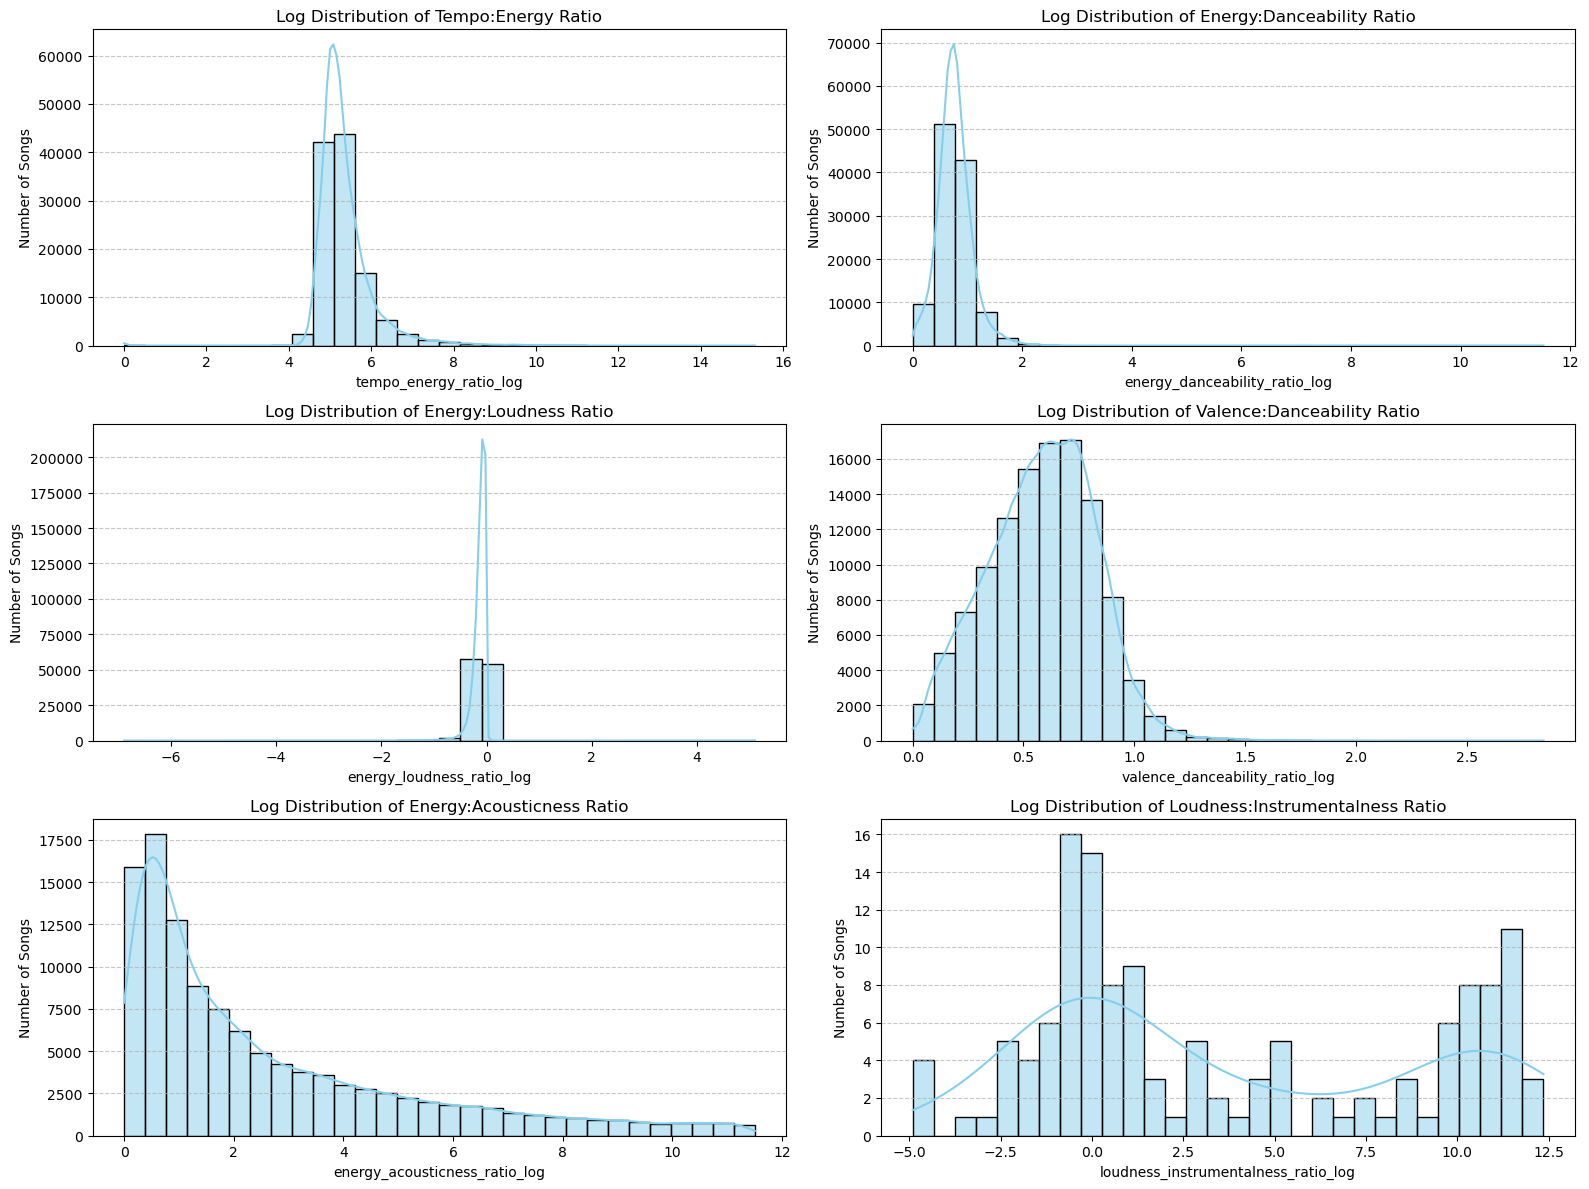

In [13]:
# Plot logged ratios
# Ratio creation function
def create_ratio_and_log(df, col1, col2, name):
    ratio_col = f'{name}_ratio'
    log_col = f'{name}_ratio_log'

    df[ratio_col] = df[col1] / (df[col2] + 1e-5)
    df[ratio_col] = df[ratio_col].replace([np.inf, -np.inf], np.nan)
    df[log_col] = np.log1p(df[ratio_col])
    df[log_col] = df[log_col].replace([np.inf, -np.inf], np.nan)
    
    return df

# Histogram plotting function that takes an Axes object
def plot_ratio_hist(ax, df, log_col, title=None, color='skyblue'):
    sns.histplot(df[log_col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(title or f'Distribution of {log_col}')
    ax.set_xlabel(log_col)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Define all ratios
ratios_to_generate = [
    ('tempo', 'energy', 'tempo_energy'),
    ('energy', 'danceability', 'energy_danceability'),
    ('energy', 'loudness', 'energy_loudness'),
    ('valence', 'danceability', 'valence_danceability'),
    ('energy', 'acousticness', 'energy_acousticness'),
    ('loudness', 'instrumentalness', 'loudness_instrumentalness')
]

# Apply all ratios
for col1, col2, name in ratios_to_generate:
    df = create_ratio_and_log(df, col1, col2, name)

# Set up 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each histogram
for ax, (_, _, name) in zip(axes, ratios_to_generate):
    log_col = f'{name}_ratio_log'
    title = f'Log Distribution of {name.replace("_", ":").title()} Ratio'
    plot_ratio_hist(ax, df, log_col, title)

plt.tight_layout()
plt.show()


In [14]:
# Create 'workout_type' (weighted scoring)
def assign_workout_type(row):
    # Non-workout conditions
    if (
        'white noise' in str(row['track_name']).lower()
        or 'nature sounds' in str(row['track_name']).lower()
        or row['speechiness'] > 0.66
        or row['duration_ms'] < 60 * 1000
        or row['duration_ms'] > 15 * 60 * 1000
        or row['acousticness'] > 0.9
    ):
        return 'non-workout'

    scores = {
        'sprint': 0,
        'interval': 0,
        'climb': 0,
        'warm up': 0,
        'cool down': 0
    }

    # Tempo
    if row['tempo'] > 140:
        scores['sprint'] += 2
    elif 125 < row['tempo'] <= 140:
        scores['interval'] += 2
    elif 110 < row['tempo'] <= 125:
        scores['climb'] += 2
    elif 85 <= row['tempo'] <= 110:
        scores['warm up'] += 2
    elif row['tempo'] < 85:
        scores['cool down'] += 2

    # Energy
    if row['energy'] > 0.9:
        scores['sprint'] += 2
    elif 0.8 < row['energy'] <= 0.9:
        scores['sprint'] += 1
        scores['interval'] += 2
    elif 0.55 < row['energy'] <= 0.8:
        scores['climb'] += 2
    elif row['energy'] < 0.5:
        scores['cool down'] += 3
        scores['warm up'] += 3

    # Valence
    if row['valence'] > 0.7:
        scores['sprint'] += 1
        scores['warm up'] += 1
    elif 0.5 <= row ['valence'] <= 0.7:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['valence'] < 0.5:
        scores['cool down'] += 3

    # Danceability
    if row['danceability'] > 0.65:
        scores['sprint'] += 1
        scores['interval'] += 1
        scores['climb'] += 1
    elif 0.4 <= row['danceability'] <= 0.65:
        scores['warm up'] += 1
    elif row['danceability'] < 0.4:
        scores['cool down'] += 1

    # Loudness
    if row['loudness'] > -5:
        scores['sprint'] += 1
    elif -10 <= row['loudness'] <= -5:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['loudness'] < -15:
        scores['cool down'] += 2

    # Instrumentalness
    if row['instrumentalness'] > 0.8:
        scores['cool down'] += 2
        scores['warm up'] += 1
    elif row['instrumentalness'] < 0.2:
        scores['sprint'] += 1
        scores['interval'] += 1

    # Speechiness (low values = music, high = spoken word)
    if 0.30 < row['speechiness'] <= 0.60:
        scores['cool down'] += 1
        scores['warm up'] += 1
    
    # Acousticness
    if 0.8 < row['acousticness'] >= 0.9:
        scores['cool down'] += 1


    return max(scores, key=scores.get) if max(scores.values()) > 0 else 'non-workout'


In [15]:
# # Creat 'workout_type' (simple)
# # Add column for workout type on subset
# def assign_workout_type(row):
#     tempo = row['tempo']
#     energy = row['energy']
#     valence = row['valence']
#     danceability = row['danceability']
    
#     if tempo > 130 and energy > 0.8 and valence > 0.3 and danceability > 0.55:
#         return 'sprint'
#     elif 120 <= tempo <= 130 and energy > 0.7:
#         return 'interval'
#     elif 110 <= tempo < 130 and 0.6 <= energy <= 0.8:
#         return 'climb'
#     elif 80 <= tempo < 110 and energy < 0.6 and valence > 0.3:
#         return 'warm up'
#     elif tempo < 100 and energy < 0.5 and valence > 0.4:
#         return 'cool down'
#     else:
#         return None  # leave ambiguous ones blank, this is where ML will come in

In [16]:
# Sample for heuristic labeling
sample_size = int(len(df) * 0.5) # taking 50% of the original dataset
sample_df = df.sample(sample_size, random_state=42).copy()

# Apply heuristic labeling function
sample_df['workout_type'] = sample_df.apply(assign_workout_type, axis=1)

# Filter labeled rows only
training_data = sample_df.dropna(subset=['workout_type'])

print("Labeled rows:", len(training_data))
print(training_data['workout_type'].value_counts())

Labeled rows: 57000
workout_type
sprint         15947
cool down      12262
climb          10013
interval        9624
non-workout     5251
warm up         3903
Name: count, dtype: int64


In [17]:
# Inspect training data
# Filter to genre 
pop_training_data = training_data[training_data['track_genre'] == 'pop']

# Show 5 random pop songs per workout type
for workout in pop_training_data['workout_type'].unique():
    print(f"\n{workout.upper()} examples:")
    display(
        pop_training_data[
            pop_training_data['workout_type'] == workout
        ][['track_name', 'artists', 'tempo', 'energy', 'valence', 'danceability']].sample(3, random_state=42)
    )



SPRINT examples:


,track_name,artists,tempo,energy,valence,danceability
81707,Leave the Door Open,Bruno Mars;Anderson .Paak;Silk Sonic,148.088,0.616,0.719,0.586
81553,Sorry,Justin Bieber,99.945,0.760,0.410,0.654
81242,Overpass Graffiti,Ed Sheeran,175.908,0.849,0.774,0.520



CLIMB examples:


,track_name,artists,tempo,energy,valence,danceability
81660,Ilzaam (From the Album 'Industry'),Arjun Kanungo;King,93.011,0.660,0.301,0.697
81632,Ayyayo,G. V. Prakash;S. P. Balasubrahmanyam;S.P. Char...,75.031,0.705,0.733,0.608
81581,SI TÚ SUPIERAS,Feid,174.972,0.664,0.586,0.673



INTERVAL examples:


,track_name,artists,tempo,energy,valence,danceability
81375,Ishqam,Mika Singh;Ali Quli Mirza,100.017,0.839,0.609,0.735
81523,How You Like That,BLACKPINK,130.018,0.787,0.326,0.813
81312,Hold On,Justin Bieber,139.980,0.634,0.290,0.658



WARM UP examples:


,track_name,artists,tempo,energy,valence,danceability
81134,Stereo Hearts (feat. Adam Levine),Gym Class Heroes;Adam Levine,89.990,0.795,0.796,0.646
81316,Teri Hogaiyaan,Vishal Mishra,106.322,0.430,0.510,0.404
81059,Dandelions - slowed + reverb,Ruth B.;slater,101.699,0.715,0.258,0.573



COOL DOWN examples:


,track_name,artists,tempo,energy,valence,danceability
81789,"Jab Tak (From ""M.S.Dhoni - The Untold Story"")",Armaan Malik,121.723,0.447,0.3210,0.299
81549,Dangerous - David Guetta Banging Remix,David Guetta;Sam Martin,128.004,0.931,0.0825,0.698
81389,Ennodu Nee Irundhaal,A.R. Rahman;Sid Sriram;Sunitha Sarathy,158.125,0.603,0.2070,0.261



NON-WORKOUT examples:


,track_name,artists,tempo,energy,valence,danceability
81830,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438
81843,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438
81888,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438


/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_62317/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_62317/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_62317/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


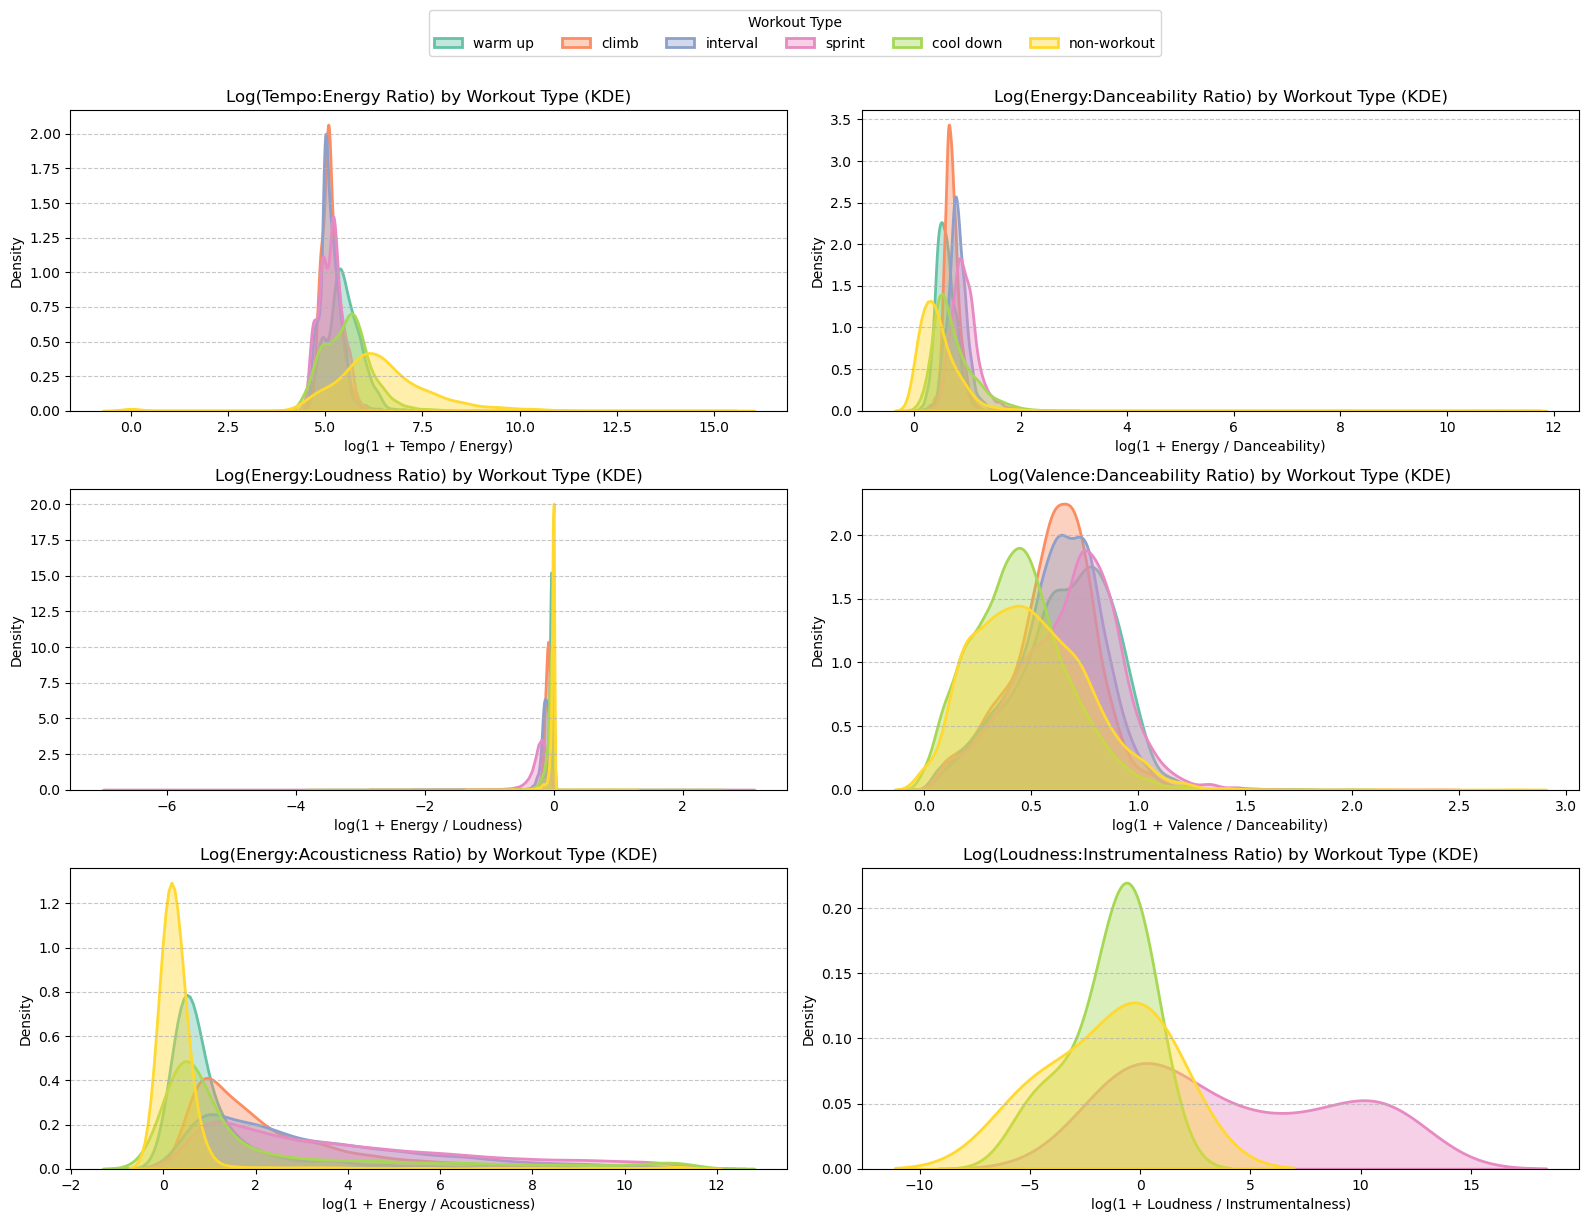

In [18]:
#Plot ratio features by workout type
def plot_kde_by_workout(ax, data, feature, title, xlabel, workouts=None, colors=None):
    if workouts is None:
        workouts = ['warm up', 'climb', 'interval', 'sprint', 'cool down', 'non-workout']
    
    if colors is None:
        colors = sns.color_palette('Set2', len(workouts))

    for workout, color in zip(workouts, colors):
        subset = data[data['workout_type'] == workout]
        sns.kdeplot(
            subset[feature],
            ax=ax,
            label=workout,
            fill=True,
            alpha=0.4,
            linewidth=2,
            color=color
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Features to plot
plot_features = [
    ('tempo_energy_ratio_log', 'Log(Tempo:Energy Ratio) by Workout Type (KDE)', 'log(1 + Tempo / Energy)'),
    ('energy_danceability_ratio_log', 'Log(Energy:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Energy / Danceability)'),
    ('energy_loudness_ratio_log', 'Log(Energy:Loudness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Loudness)'),
    ('valence_danceability_ratio_log', 'Log(Valence:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Valence / Danceability)'),
    ('energy_acousticness_ratio_log', 'Log(Energy:Acousticness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Acousticness)'),
    ('loudness_instrumentalness_ratio_log', 'Log(Loudness:Instrumentalness Ratio) by Workout Type (KDE)', 'log(1 + Loudness / Instrumentalness)')
]

# Create 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to easily iterate

# Plot all features
for ax, (feature, title, xlabel) in zip(axes, plot_features):
    plot_kde_by_workout(ax, training_data, feature, title, xlabel)

# Final touches
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Workout Type", loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for legend
plt.show()


- Tempo:Energy Ratio shows most workout types clustered between 5 and 6. Non-workout has a greater span. 
- Energy:Danceability Ratio again shows clustering of workout types. It may help separate higher intensity workouts (sprint & interval) from others. 
- Energy:Loudness Ratio shows all classes tightly clustered at 0. Minimal discriminatory weight, we'll drop this from the pipeline features.
- Valence:Danceability Ratio shows moderate overlap between all types. However, warm-up, cool-down, and non-workout seem slightly skewed left compared to more intense workouts (like sprint and interval). Valence (emotional positivity) may be lower relative to danceability in non-workout or cool-down music.
- Energy:Acousticness Ratio shows warm-up, cool down, and non-workout all skewed further left. Could be effective distinguishing low-energy, more acoustic tracks (used for cool down or non-workout) from high-energy, synthetic workout tracks. 
- Lots of missing values for Loudness:Instrumentalness which won't help separate workout classifications. 

## Pipeline Build + Model Deployment

In [19]:
# Split data
# # Using the manual label column as the primary then filling in with workout_type
# training_data.loc[:, 'label'] = training_data['manual_label'].fillna(training_data['workout_type'])

# Define features
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']
features = numeric_features + categorical_features

X = training_data[features]
y = training_data['workout_type'] 

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)

In [20]:
# Define preprocessor: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

    # Fit the pipeline
    pipeline.fit(X_train, y_train_enc, clf__sample_weight=sample_weights)

    # Make predictions (this part was missing)
    y_pred_enc = pipeline.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_enc)
    y_test_decoded = label_encoder.inverse_transform(y_test_enc)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_decoded, y_pred))



Random Forest Classification Report:
              precision    recall  f1-score   support

       climb       0.95      0.96      0.96      3004
   cool down       0.94      0.97      0.95      3679
    interval       0.97      0.95      0.96      2887
 non-workout       1.00      0.94      0.97      1575
      sprint       0.97      0.98      0.97      4784
     warm up       0.93      0.89      0.91      1171

    accuracy                           0.96     17100
   macro avg       0.96      0.95      0.95     17100
weighted avg       0.96      0.96      0.96     17100


XGBoost Classification Report:
              precision    recall  f1-score   support

       climb       0.99      1.00      0.99      3004
   cool down       0.98      0.98      0.98      3679
    interval       0.99      0.99      0.99      2887
 non-workout       0.98      0.94      0.96      1575
      sprint       0.99      0.99      0.99      4784
     warm up       0.98      0.98      0.98      1171

    acc

In [21]:
# Stratified K-Fold

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in cv.split(X, y_encoded):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_cv)

    pipeline.fit(X_train_cv, y_train_cv, clf__sample_weight=sample_weights)
    y_pred_cv = pipeline.predict(X_test_cv)

    score = f1_score(y_test_cv, y_pred_cv, average='macro')
    scores.append(score)

print("Stratified K-Fold F1 Macro Scores:", scores)
print("Average F1 Macro Score:", np.mean(scores))


Stratified K-Fold F1 Macro Scores: [0.9785500633474286, 0.9838140114393572, 0.9812969766801404, 0.977601454381729, 0.9785951866745007]
Average F1 Macro Score: 0.9799715385046313


In [22]:
# RandomizedSearchCV
# ColumnTransformer setup
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Parameter space
param_dist = {
    'clf__n_estimators': [100, 200, 250, 300],
    'clf__max_depth': [3, 5, 7, 9, 10],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    # extra additions to improve CV
    'clf__gamma': [0, 0.1, 0.3, 0.5],
    'clf__min_child_weight': [1, 3, 5]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='f1_macro',
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train_enc)

# Best model
print("Best params:", random_search.best_params_)
print("Best F1 Macro Score:", random_search.best_score_)


Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 250, 'clf__min_child_weight': 1, 'clf__max_depth': 5, 'clf__learning_rate': 0.3, 'clf__gamma': 0.5, 'clf__colsample_bytree': 1.0}
Best F1 Macro Score: 0.9784388067008851


Interesting that this is sliiiiiightly lower than the XGBoost CV score. I fear we've reached a performance ceiling. Thankfully they're both hovering around .98, which is an excellent result either way. 

In [23]:
# Save model
import joblib
joblib.dump(random_search.best_estimator_, 'workout_classifier.pkl')

['workout_classifier.pkl']

<Figure size 1000x800 with 0 Axes>

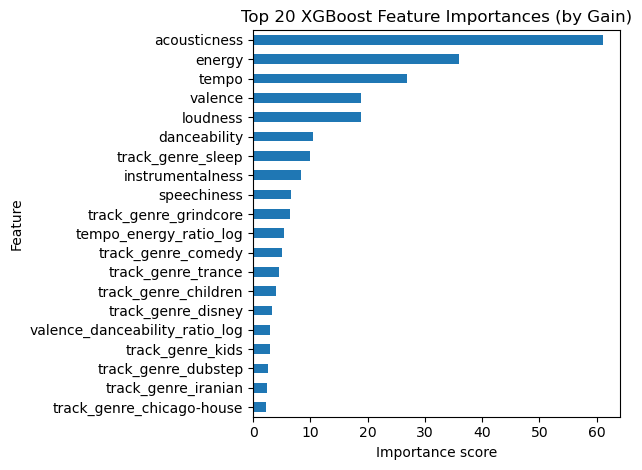

In [24]:
# Visualize feature importance

# Load trained pipeline and extract steps
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Get feature names
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# Map feature importances
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance],
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='Feature', y='Gain', legend=False)
plt.title("Top 20 XGBoost Feature Importances (by Gain)")
plt.xlabel("Importance score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 98%|===================| 1172/1200 [00:15<00:00]        

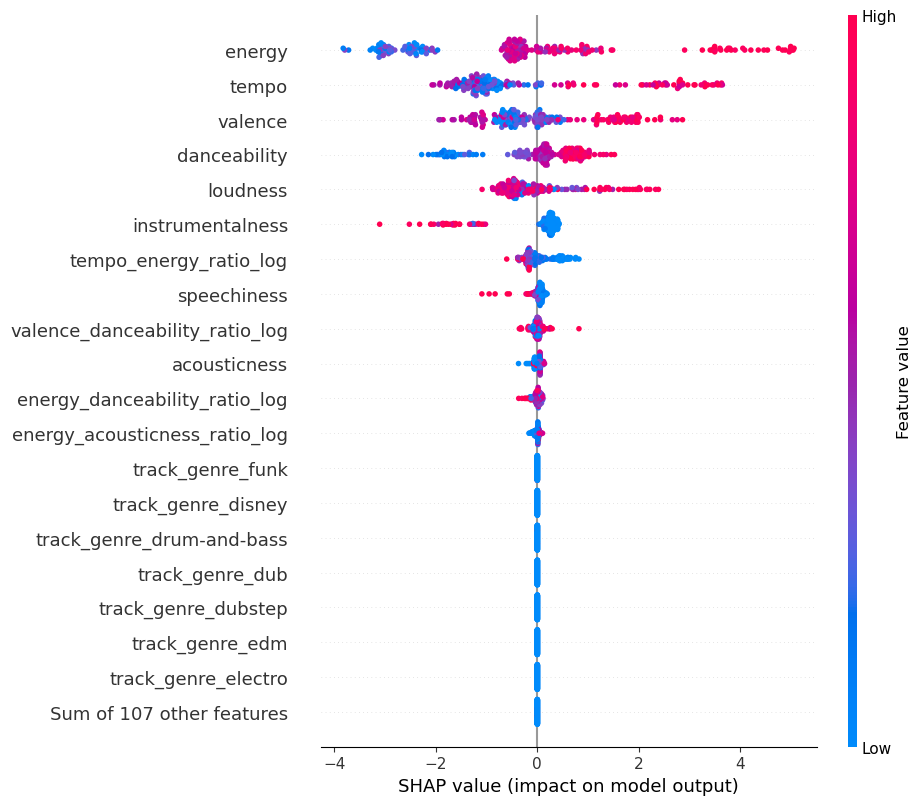

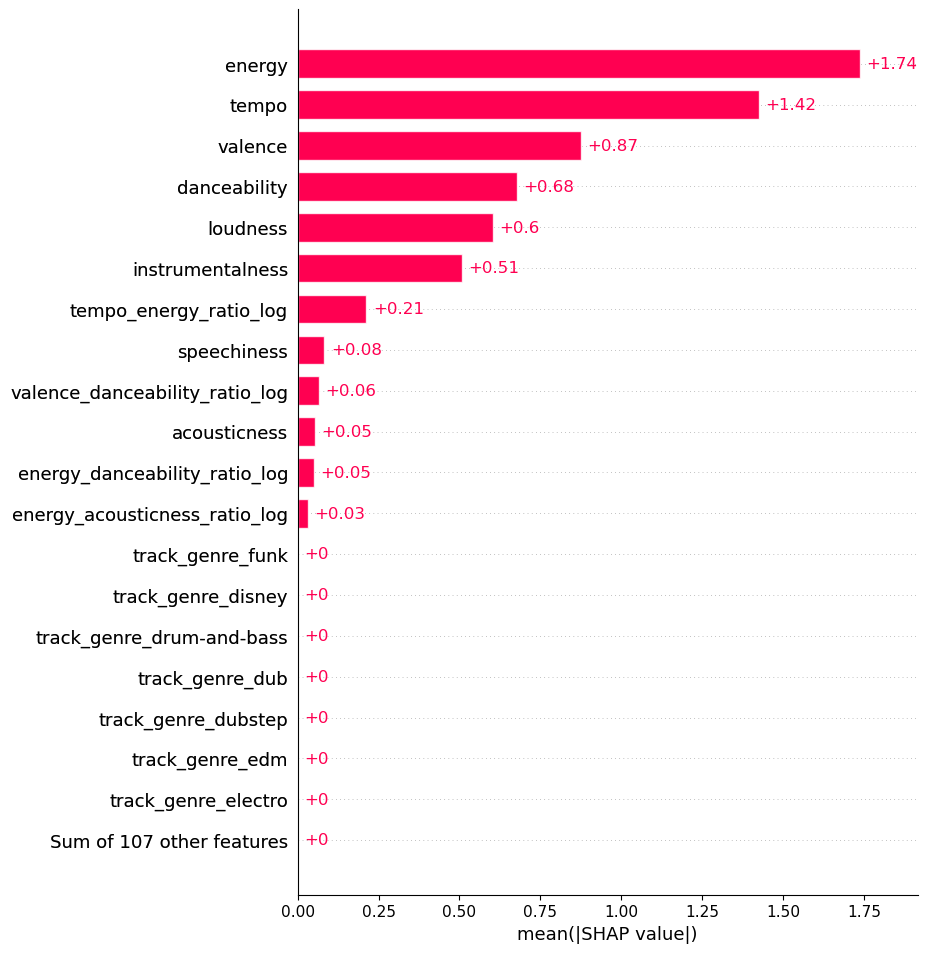

In [25]:
# SHAP
# Load the pipeline again
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Prepare transformed training data
X_train_transformed = preprocessor.transform(X_train).toarray()

# Get feature names after transformation
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# SHAP Explainer for XGBoost
explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)

# Compute SHAP values for a sample
shap_values = explainer(X_train_transformed[:200])

# Plot chart
class_name = 'sprint'  # Change this to another workout type as needed!
class_index = list(label_encoder.classes_).index(class_name)

# Extract SHAP values for this class
shap_values_class = shap_values[..., class_index]

# Beeswarm plot (local interpretability)
shap.plots.beeswarm(shap_values_class, max_display=20)

# Bar plot (global importance)
shap.plots.bar(shap_values_class, max_display=20)

<Figure size 1000x700 with 0 Axes>

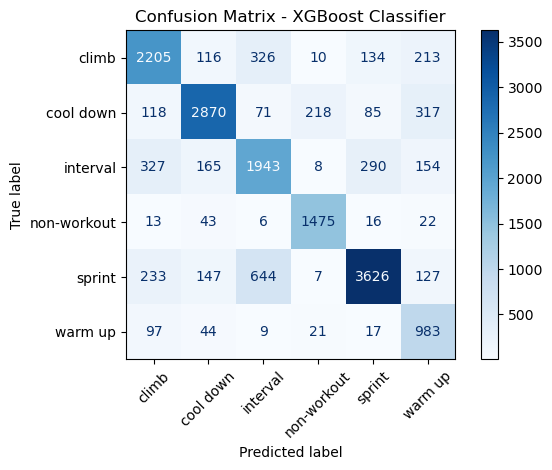

In [26]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred, labels=label_encoder.classes_)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot it
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


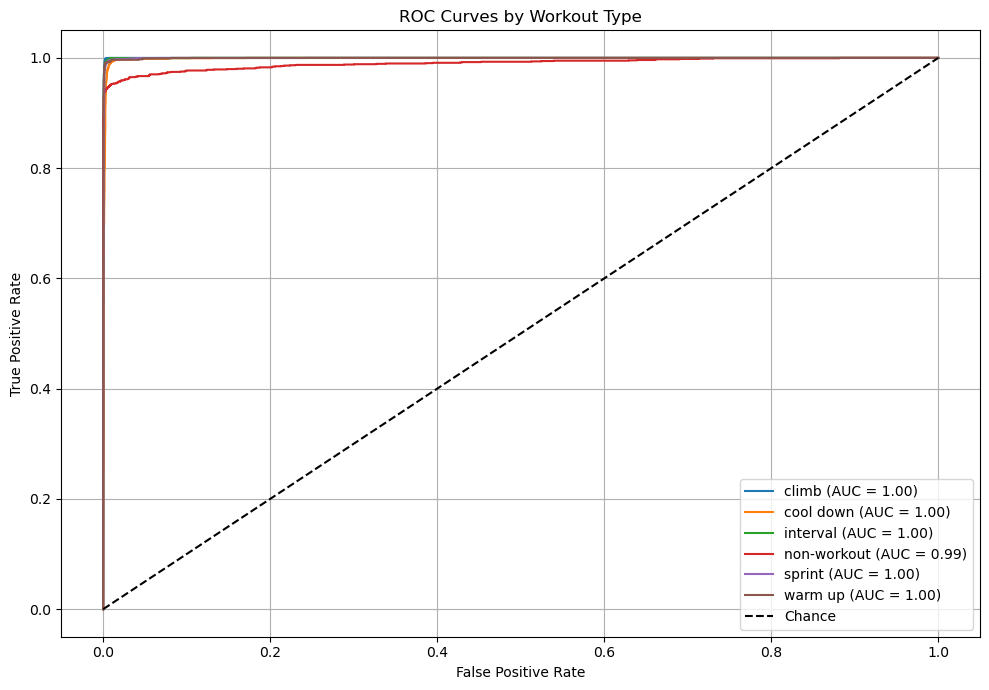

In [27]:
# ROC-AUC

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
y_score = best_model.predict_proba(X_test)

# Create ROC curve for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves by Workout Type")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Results show clear separation between classes; the model is highly confident at distinguishing workout types. Non-workout AUC is slightly lower, but expected due to the nature of this class. 

In [28]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Apply model to unlabeled songs
unlabeled_songs = df[~df['track_id'].isin(training_data['track_id'])].copy()

# Predict labels using the best model
X_unlabeled = unlabeled_songs[X_train.columns]
unlabeled_songs['workout_type'] = best_model.predict(X_unlabeled)
unlabeled_songs['workout_type'] = label_encoder.inverse_transform(unlabeled_songs['workout_type'])

# Filter out non-workout tracks
usable_songs = unlabeled_songs[unlabeled_songs['workout_type'] != 'non-workout']


In [29]:
# Sample predictions
usable_songs[['track_name', 'artists', 'track_genre', 'spin_genre', 'workout_type', 'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness']].sample(5)


,track_name,artists,track_genre,spin_genre,workout_type,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness
66656,"Itzy Bitzy Spider (Itzi, Bitzi, Araña)",Babyboomboom,kids,non-workout,climb,116.190,0.175,0.885,0.6910,-14.671,0.86600,0.000000,0.1950
112000,La Câlin,Serhat Durmus,turkish,intl/other,cool down,147.840,0.439,0.598,0.0673,-10.987,0.08790,0.868000,0.0429
85890,Ah! Eu Tô Sem Erva - Ao Vivo,Comunidade Nin-jitsu,punk-rock,rock/alt,sprint,127.881,0.917,0.513,0.3430,-4.728,0.01000,0.000129,0.1230
50432,Desde el Oeste - En Vivo All Boys,Almafuerte,heavy-metal,rock/alt,interval,90.342,0.833,0.282,0.4040,-6.868,0.02790,0.000004,0.0370
109652,Nebel,Droplex;Mark Dekoda,techno,pop/edm,interval,128.001,0.533,0.934,0.1500,-6.170,0.00694,0.447000,0.0789


## Workout Type Feature Distribution

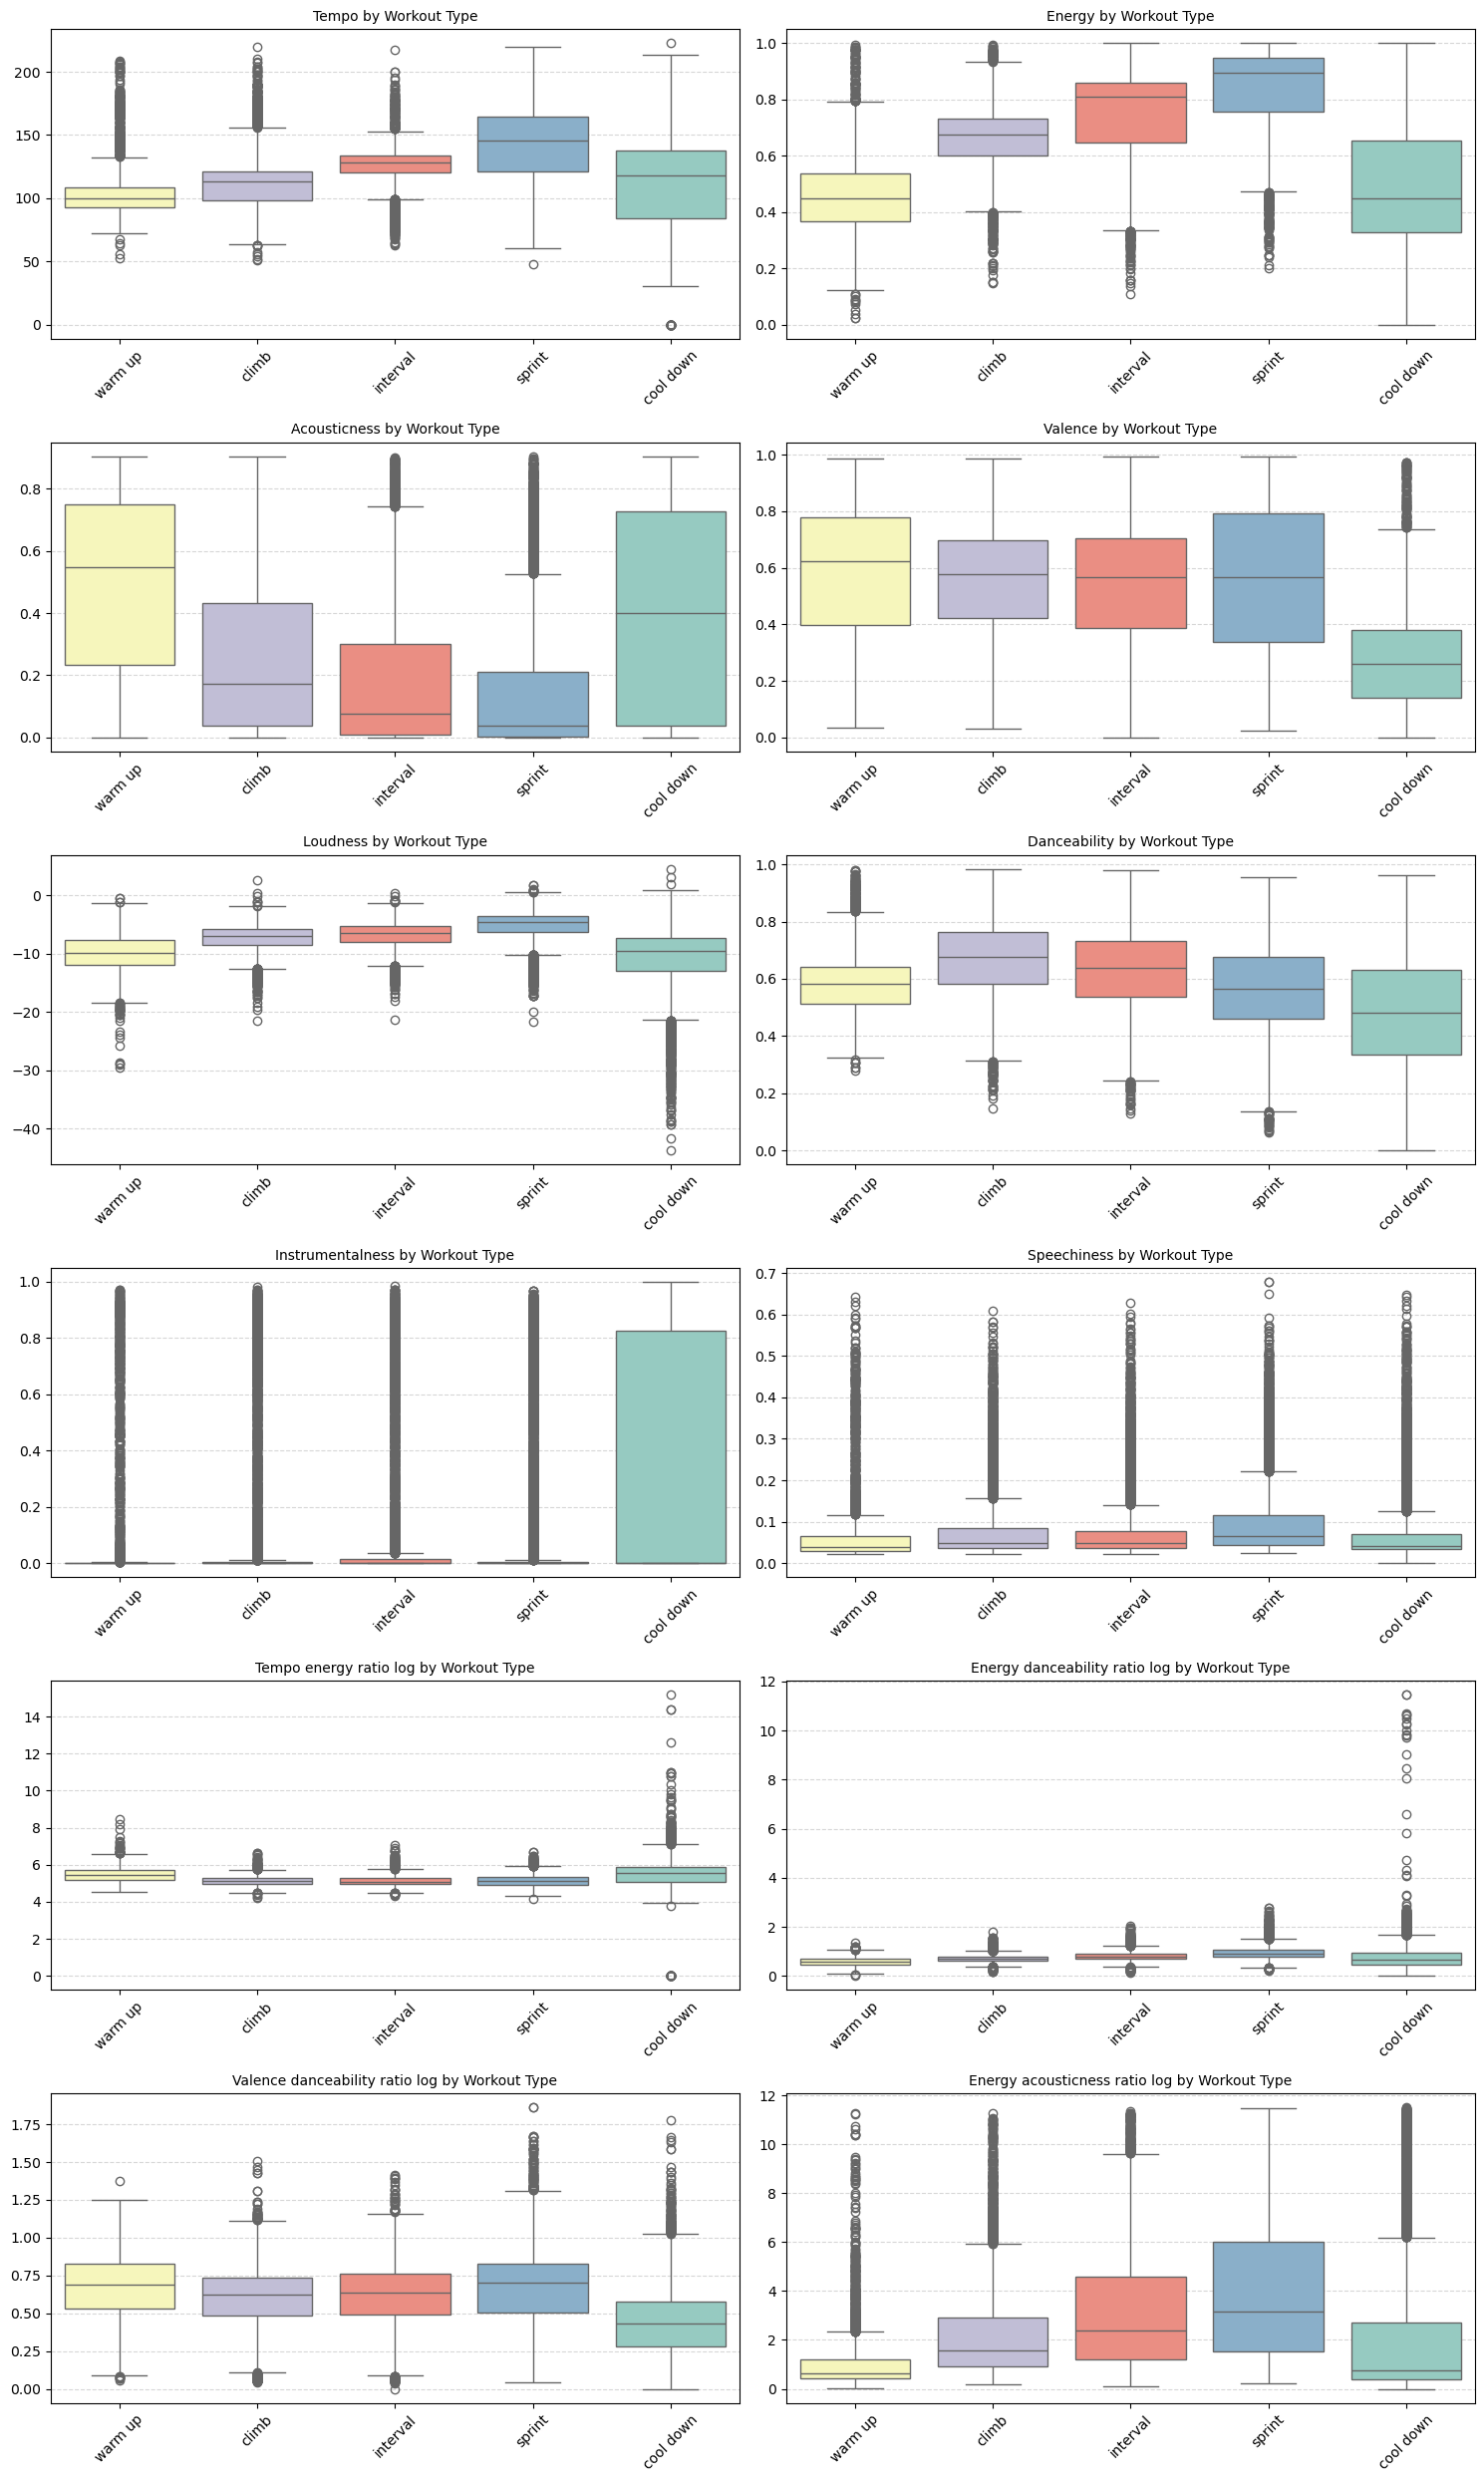

In [30]:
# Features to visualize + order
features = [
    'tempo', 'energy', 'acousticness', 'valence', 'loudness', 'danceability', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
workout_order = ['warm up', 'climb', 'interval', 'sprint', 'cool down']

# Set up the subplot grid
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
axes = axes.flatten()  # flatten to easily iterate

# Loop through each feature and create a boxplot grouped by predicted workout type
for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.boxplot(
        data=usable_songs,
        x='workout_type',
        y=feature,
        hue='workout_type',
        palette='Set3',
        order=workout_order,
        ax=ax,
        legend=False
    )
    ax.set_title(f'{feature.replace("_", " ").capitalize()} by Workout Type', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any empty subplots if features < total grid size
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

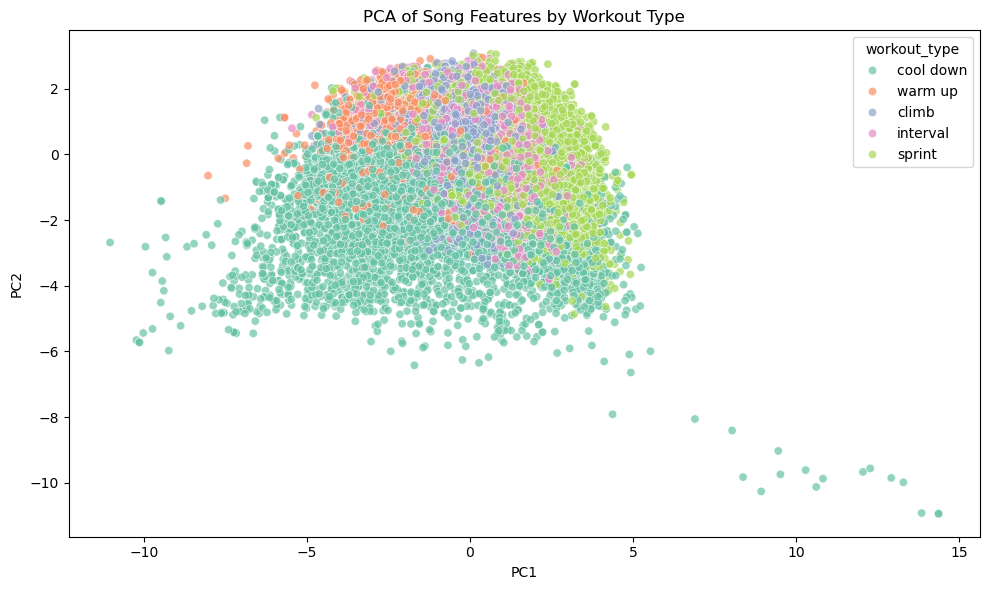

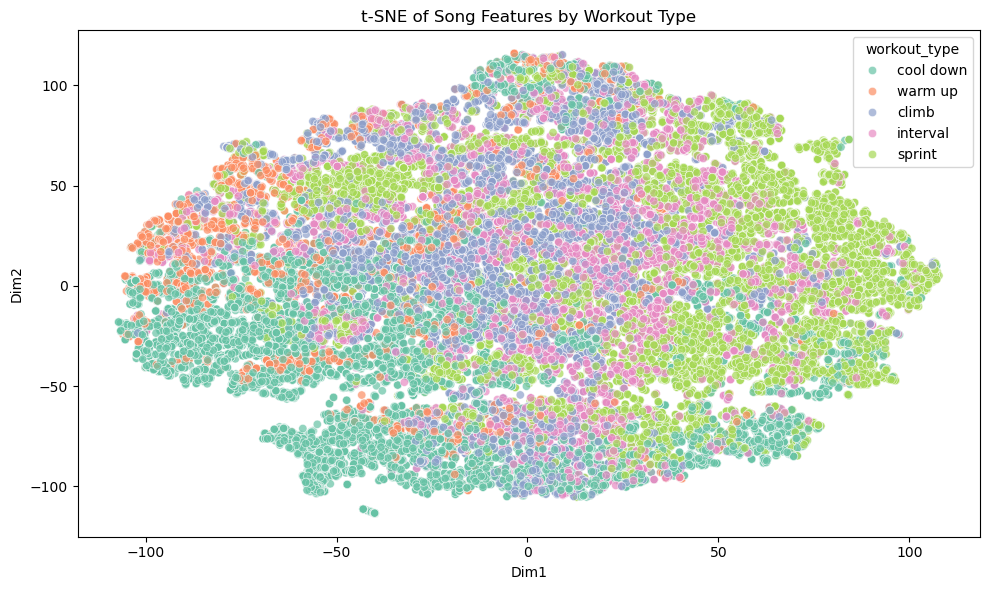

In [31]:
# PCA and t-SNE test
# Select features to embed
features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
X = usable_songs[features].dropna()
y = usable_songs.loc[X.index, 'workout_type']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("PCA of Song Features by Workout Type")
plt.tight_layout()
plt.show()

# t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("t-SNE of Song Features by Workout Type")
plt.tight_layout()
plt.show()


PCA
- Lots of overlap here. Indicates songs share similar feature profiles.
- Cool down does seem to be skewed left and sprint skewed right. Likely that PC1 encodes some combination of energy, tempo, and/or acousticness.
- Cool down dominates sparse regions, meaning it has the widest variance. 
- Confirms that XGBoost's supervised learning is best to make sense of these patterns. 

t-SNE
- Shows more distinct regions of local grouping than PCA (sprint being the most distinct) 
- Warm up and cool down are less distinct than sprint, but still show consistent trends in how t-SNE clusters them. 
- Climb and interval are the most entangled, though are arguably closest in classification.	

In [32]:
# See how much each original feature contributes to PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print(loadings)


                                     PC1       PC2
tempo                           0.086041  0.004166
energy                          0.478503  0.080570
danceability                   -0.082529  0.370672
valence                         0.040535  0.594268
loudness                        0.371139  0.209778
acousticness                   -0.398293  0.077444
instrumentalness                0.003330 -0.366021
speechiness                     0.073020  0.080329
tempo_energy_ratio_log         -0.388420 -0.080663
energy_danceability_ratio_log   0.372828 -0.216727
valence_danceability_ratio_log  0.102115  0.463864
energy_acousticness_ratio_log   0.391351 -0.209438


- PC1 is clearly an “intensity” axis.
- PC2 is an “emotional tone / accessibility” axis.

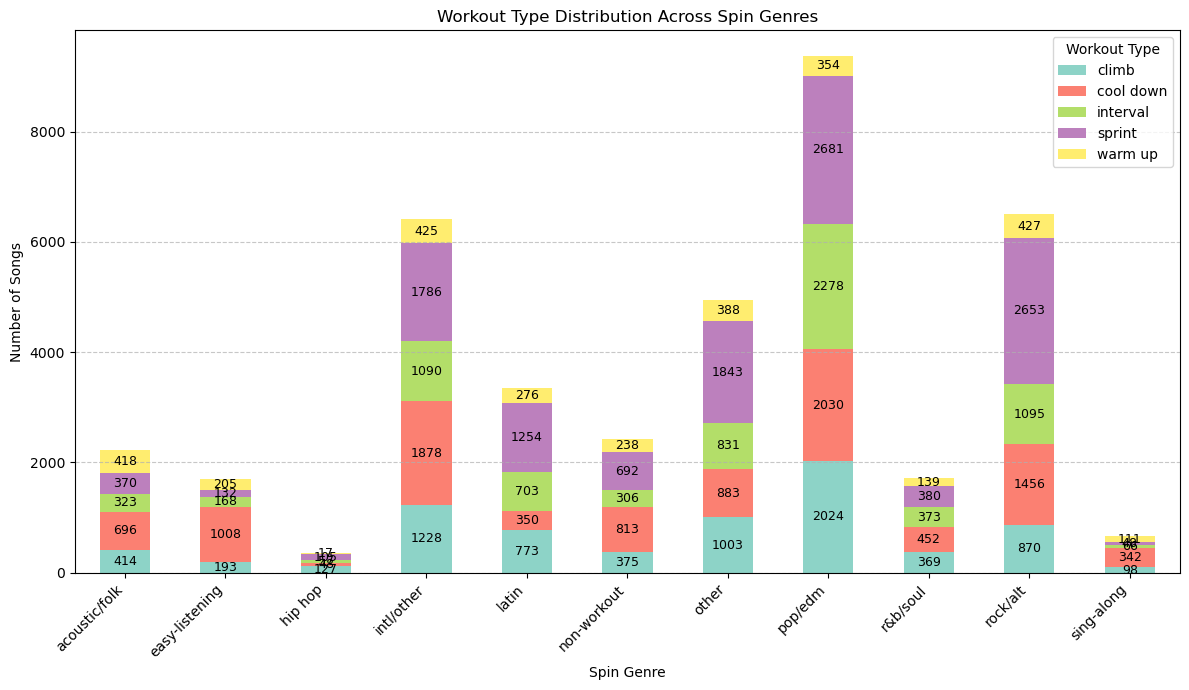

In [33]:
# Plot workout type by genre
# Create pivot table
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Plot stacked bar chart
ax = genre_label_counts.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

# Add value labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Format chart
plt.title("Workout Type Distribution Across Spin Genres")
plt.xlabel("Spin Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

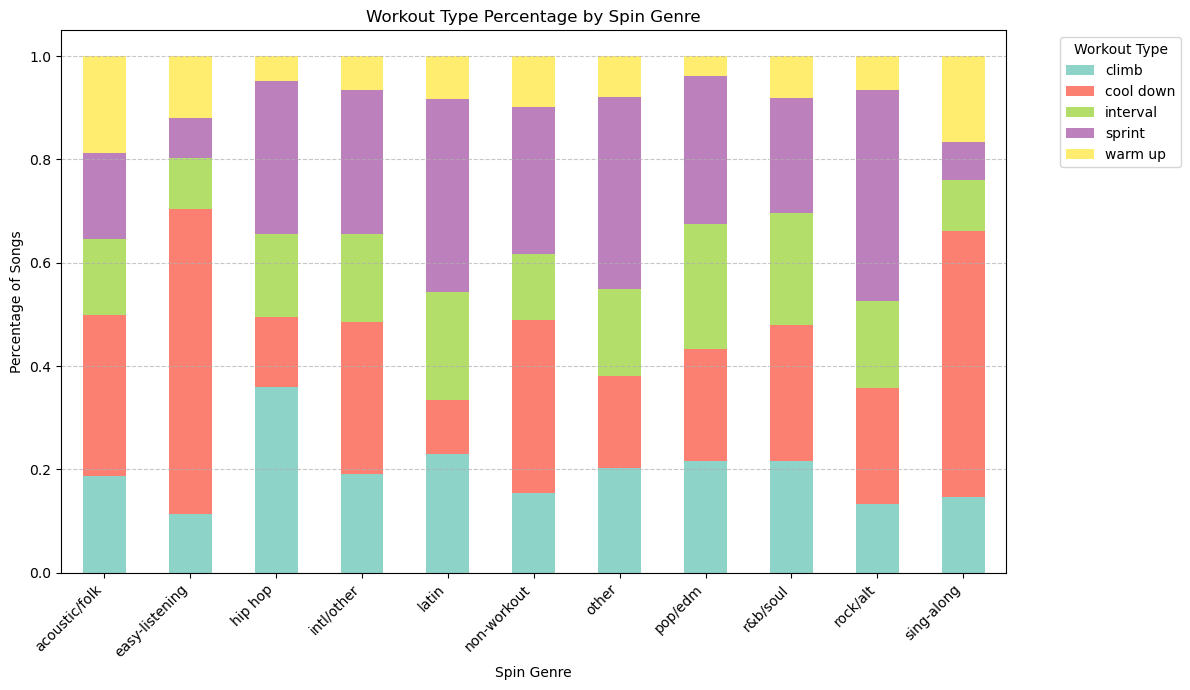

In [34]:
# Workout Type Percentage by Spin Genre
# Create pivot table of counts
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Normalize each row to get percentages
genre_label_percent = genre_label_counts.div(genre_label_counts.sum(axis=1), axis=0)

# Plot
genre_label_percent.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

plt.title("Workout Type Percentage by Spin Genre")
plt.xlabel("Spin Genre")
plt.ylabel("Percentage of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Playlist building

In [35]:
# Constant Variables
# Shared constants
playlist_structures = {
    'balanced': ['warm up', 'interval', 'sprint', 'interval', 'climb',
                 'interval', 'sprint', 'interval', 'climb', 'cool down'],
    'speed': ['warm up', 'interval', 'sprint', 'interval', 'warm up',
              'interval', 'sprint', 'interval', 'sprint', 'cool down'],
    'climb': ['warm up', 'interval', 'climb', 'interval', 'climb',
              'warm up', 'climb', 'interval', 'climb', 'cool down'],
    'recovery': ['warm up', 'interval', 'interval', 'cool down', 'interval',
                 'interval', 'cool down', 'interval', 'cool down', 'cool down']
}

spin_genres = [
    'pop/edm', 'rock/alt', 'hip hop', 'r&b/soul', 'acoustic/folk', 
    'latin', 'easy-listening', 'intl/other', 'sing-along'
]

# Shuffle songs once and reuse
usable_songs_shuffled = usable_songs.sample(frac=1, random_state=42).copy()

# Utility: Song finder
def find_song(df, workout_type, used_tracks, popularity_thresholds=[70, 55, 30, 10]):
    for threshold in popularity_thresholds:
        match = df[
            (df['workout_type'] == workout_type) &
            (df['popularity'] >= threshold) &
            (~df['track_name'].isin(used_tracks))
        ]
        if not match.empty:
            return match.sample(1).copy()
    return pd.DataFrame()

# Utility: Playlist display
def display_playlist(playlist, title=None):
    if title:
        print(f"\n{title}\n{'=' * len(title)}")
    display_df = playlist[['workout_type', 'track_name', 'artists', 'track_genre', 'tempo', 'energy', 
                           'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness',]].copy()
    display_df['spotify_url'] = "https://open.spotify.com/track/" + playlist['track_id']
    display(display_df)
    total_ms = playlist['duration_ms'].sum()
    total_min, total_sec = divmod(int(total_ms / 1000), 60)
    print(f"Total duration: {total_min} min {total_sec} sec")


### Single Playlist Generator

In [36]:
# Settings
structure_key = 'balanced'
selected_genre = 'pop/edm'

# Filter songs for the genre
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]
used_tracks = set()
playlist = pd.DataFrame()

# Generate playlist
for stage in playlist_structures[structure_key]:
    song = find_song(genre_songs, stage, used_tracks)
    if not song.empty:
        used_tracks.add(song.iloc[0]['track_name'])
        playlist = pd.concat([playlist, song], ignore_index=True)

# Display
display_playlist(playlist, title=f"Single Playlist | Genre: {selected_genre} | Structure: {structure_key}")



Single Playlist | Genre: pop/edm | Structure: balanced


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,If You Don't Know Me by Now - 2008 Remaster,Simply Red,british,94.173,0.352,0.638,0.204,-9.266,0.49200,0.000000,0.0268,https://open.spotify.com/track/7DFawVSjI88xR9m...
1,interval,Waka Waka (This Time for Africa) [The Official...,Shakira;Freshlyground,dance,126.988,0.873,0.766,0.743,-6.381,0.00627,0.000000,0.1430,https://open.spotify.com/track/2Cd9iWfcOpGDHLz...
2,sprint,Attention,Charlie Puth,dance,100.066,0.613,0.775,0.797,-4.586,0.10900,0.000023,0.0542,https://open.spotify.com/track/5cF0dROlMOK5uNZ...
3,interval,Summer,Calvin Harris,electro,127.949,0.856,0.596,0.743,-3.556,0.02110,0.017800,0.0346,https://open.spotify.com/track/6YUTL4dYpB9xZO5...
4,climb,Grapefruit,Tove Lo,synth-pop,105.000,0.684,0.724,0.163,-5.129,0.00134,0.000441,0.0342,https://open.spotify.com/track/35seOt4wMvu7gWz...
5,interval,Dark Horse,Katy Perry;Juicy J,dance,131.934,0.585,0.647,0.353,-6.123,0.00314,0.000000,0.0512,https://open.spotify.com/track/4jbmgIyjGoXjY01...
6,sprint,Under Control (feat. Hurts),Calvin Harris;Alesso;Hurts,house,126.094,0.915,0.544,0.510,-3.405,0.12900,0.000914,0.0841,https://open.spotify.com/track/4J7CKHCF3mdL4di...
7,interval,Hungry Like the Wolf - 2009 Remaster,Duran Duran,synth-pop,127.568,0.812,0.691,0.685,-7.772,0.04330,0.000001,0.0558,https://open.spotify.com/track/39lSeqnyjZJejRu...
8,climb,Brown Munde,AP Dhillon;Gminxr;Gurinder Gill;Shinda Kahlon,pop,100.024,0.611,0.854,0.417,-6.260,0.22300,0.000000,0.0864,https://open.spotify.com/track/58f4twRnbZOOVUh...
9,cool down,I Don’t Wanna Live Forever (Fifty Shades Darker),ZAYN;Taylor Swift,dance,117.970,0.445,0.731,0.106,-8.418,0.05860,0.000020,0.0533,https://open.spotify.com/track/55n9yjI6qqXh5F2...


Total duration: 36 min 31 sec


In [37]:
# Settings
structure_key = 'balanced'
selected_genre = 'pop/edm'

# Filter songs for the genre
genre_songs = usable_songs_shuffled[usable_songs_shuffled['artists'] == 'Taylor Swift']
used_tracks = set()
playlist = pd.DataFrame()

# Generate playlist
for stage in playlist_structures[structure_key]:
    song = find_song(genre_songs, stage, used_tracks)
    if not song.empty:
        used_tracks.add(song.iloc[0]['track_name'])
        playlist = pd.concat([playlist, song], ignore_index=True)

# Display
display_playlist(playlist, title=f"Single Playlist | Genre: {selected_genre} | Structure: {structure_key}")


Single Playlist | Genre: pop/edm | Structure: balanced


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,interval,Don’t Blame Me,Taylor Swift,pop,135.917,0.534,0.615,0.193,-6.719,0.1060,0.000018,0.0386,https://open.spotify.com/track/1R0a2iXumgCiFb7...
1,sprint,Wildest Dreams,Taylor Swift,pop,140.060,0.664,0.553,0.467,-7.417,0.0709,0.005600,0.0741,https://open.spotify.com/track/3fVnlF4pGqWI9fl...
2,climb,august,Taylor Swift,pop,89.937,0.623,0.532,0.403,-9.208,0.5380,0.000073,0.0331,https://open.spotify.com/track/3hUxzQpSfdDqwM3...
3,cool down,Lover,Taylor Swift,pop,68.534,0.543,0.359,0.453,-7.582,0.4920,0.000016,0.0919,https://open.spotify.com/track/1dGr1c8CrMLDpV6...


Total duration: 15 min 40 sec


### Multiple Playlists by Genre

In [38]:
# Settings
selected_genre = 'pop/edm'
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]

# Loop through each structure type
for structure_key, structure in playlist_structures.items():
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{structure_key.upper()} Ride | Genre: {selected_genre}")



BALANCED Ride | Genre: pop/edm


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Phir Bhi Tumko Chaahunga,Mithoon;Arijit Singh;Shashaa Tirupati,pop,99.638,0.525,0.527,0.257,-8.106,0.876000,0.000014,0.0337,https://open.spotify.com/track/35P2Xal9x3GAdOH...
1,interval,Waka Waka (This Time for Africa) [The Official...,Shakira;Freshlyground,dance,126.988,0.873,0.766,0.743,-6.381,0.006270,0.000000,0.1430,https://open.spotify.com/track/2Cd9iWfcOpGDHLz...
2,sprint,Reptilia,The Strokes,garage,158.009,0.649,0.489,0.770,-5.110,0.000603,0.713000,0.0336,https://open.spotify.com/track/57Xjny5yNzAcsxn...
3,interval,Summer,Calvin Harris,progressive-house,127.949,0.856,0.596,0.743,-3.556,0.021100,0.017800,0.0346,https://open.spotify.com/track/6YUTL4dYpB9xZO5...
4,climb,Questions,Lost Frequencies;James Arthur,edm,123.962,0.713,0.599,0.518,-7.008,0.405000,0.000025,0.0542,https://open.spotify.com/track/1cgy2FSOQMbq7DH...
5,interval,I'm So Happy (with BENEE),Jeremy Zucker;BENEE,electro,132.899,0.434,0.846,0.681,-7.118,0.642000,0.000000,0.1180,https://open.spotify.com/track/16Fxe5DvEXRxQwc...
6,sprint,Power,Little Mix,dance,172.966,0.855,0.566,0.517,-4.016,0.037200,0.000157,0.2110,https://open.spotify.com/track/0lUSd7TCG8srh6H...
7,interval,Save Your Tears,The Weeknd,pop,118.051,0.826,0.680,0.644,-5.487,0.021200,0.000012,0.0309,https://open.spotify.com/track/5QO79kh1waicV47...
8,climb,I Want It That Way,Backstreet Boys,dance,99.039,0.694,0.689,0.482,-5.830,0.257000,0.000000,0.0270,https://open.spotify.com/track/47BBI51FKFwOMlI...
9,cool down,I Don’t Wanna Live Forever (Fifty Shades Darker),ZAYN;Taylor Swift,dance,117.970,0.445,0.731,0.106,-8.418,0.058600,0.000020,0.0533,https://open.spotify.com/track/55n9yjI6qqXh5F2...


Total duration: 37 min 51 sec

SPEED Ride | Genre: pop/edm


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Chola Chola,Sathyaprakash;VM Mahalingam;Nakul Abhyankar,pop,99.739,0.655,0.623,0.749,-9.998,0.3040,0.000000,0.2030,https://open.spotify.com/track/27nzJVsvXqXyeMI...
1,interval,Eyes Off You,PRETTYMUCH,dance,106.027,0.512,0.631,0.529,-9.675,0.5110,0.000000,0.0572,https://open.spotify.com/track/0VpEX8ib3wE7u8N...
2,sprint,Self Control,Laura Branigan,disco,106.679,0.686,0.814,0.778,-12.172,0.2190,0.003820,0.0342,https://open.spotify.com/track/6JNJERZGJwDVgkm...
3,interval,Don’t Blame Me,Taylor Swift,pop,135.917,0.534,0.615,0.193,-6.719,0.1060,0.000018,0.0386,https://open.spotify.com/track/1R0a2iXumgCiFb7...
4,warm up,Perfect,Ed Sheeran,pop,95.050,0.448,0.599,0.168,-6.312,0.1630,0.000000,0.0232,https://open.spotify.com/track/0tgVpDi06FyKpA1...
5,interval,I.F.L.Y.,Bazzi,electro,104.954,0.519,0.812,0.554,-4.823,0.3790,0.000000,0.0385,https://open.spotify.com/track/4a6q8CR2hzLk2pl...
6,sprint,Vegas (From the Original Motion Picture Soundt...,Doja Cat,dance,159.969,0.601,0.801,0.740,-7.574,0.0777,0.000032,0.2550,https://open.spotify.com/track/0hquQWY3xvYqN4q...
7,interval,Escape (feat. Hayla),Kx5;deadmau5;Kaskade;Hayla,edm,126.080,0.799,0.660,0.148,-6.934,0.1790,0.000364,0.0719,https://open.spotify.com/track/10oKSzRcwbZsog2...
8,sprint,Alone,Marshmello,edm,141.990,0.953,0.631,0.422,-3.739,0.0241,0.015500,0.0343,https://open.spotify.com/track/3MEYFivt6bilQ9q...
9,cool down,Homage,Mild High Club,garage,73.369,0.465,0.546,0.415,-8.167,0.1530,0.002590,0.0287,https://open.spotify.com/track/7DcJ6fEBb7BaKuY...


Total duration: 36 min 50 sec

CLIMB Ride | Genre: pop/edm


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Imagination,Shawn Mendes,dance,89.948,0.455,0.640,0.333,-5.942,0.0743,0.000000,0.0247,https://open.spotify.com/track/21TcDbGosp7w9Yh...
1,interval,Satisfaction,David Guetta;Benny Benassi,edm,126.022,0.935,0.752,0.310,-6.263,0.0742,0.035200,0.2030,https://open.spotify.com/track/0lwyzp7GppQxv0E...
2,climb,Roses - Imanbek Remix,SAINt JHN;Imanbek,house,121.975,0.724,0.770,0.898,-5.484,0.0167,0.010700,0.0495,https://open.spotify.com/track/24Yi9hE78yPEbZ4...
3,interval,I Just Called,NEIKED;Anne-Marie;Latto,house,138.997,0.849,0.626,0.898,-3.662,0.0732,0.000000,0.1230,https://open.spotify.com/track/0H8Tclo4x4kbZru...
4,climb,ily (i love you baby) (feat. Emilee),Surf Mesa;Emilee,house,112.050,0.774,0.674,0.330,-7.567,0.0686,0.001880,0.0892,https://open.spotify.com/track/62aP9fBQKYKxi7P...
5,warm up,Numbers,TEMPOREX,garage,93.958,0.332,0.423,0.500,-10.761,0.4740,0.000000,0.0288,https://open.spotify.com/track/4GuZMzKXJSoWhwH...
6,climb,Daddy Cool,Boney M.,disco,124.431,0.777,0.763,0.929,-6.932,0.2810,0.790000,0.0364,https://open.spotify.com/track/3WMbD1OyfKuwWDW...
7,interval,I Was Made For Lovin' You (feat. Nile Rodgers ...,Oliver Heldens;Nile Rodgers;House Gospel Choir,progressive-house,126.030,0.892,0.686,0.752,-3.186,0.0577,0.000007,0.0498,https://open.spotify.com/track/2LxdNADWier3MKT...
8,climb,Fetish (feat. Gucci Mane),Selena Gomez;Gucci Mane,dance,123.013,0.618,0.708,0.265,-4.424,0.0204,0.000007,0.0592,https://open.spotify.com/track/4lnAN2S1fcI0Sjx...
9,cool down,"Rait Zara Si (From ""Atrangi Re"")",A.R. Rahman;Arijit Singh;Shashaa Tirupati,pop,125.998,0.495,0.563,0.244,-10.272,0.7810,0.000000,0.0362,https://open.spotify.com/track/4uK0M8AI6gyFmyz...


Total duration: 30 min 48 sec

RECOVERY Ride | Genre: pop/edm


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,What's Love Got to Do with It,Tina Turner,disco,97.840,0.406,0.851,0.792,-11.631,0.21900,0.000006,0.0661,https://open.spotify.com/track/4kOfxxnW1ukZdsN...
1,interval,everything sucks,vaultboy,pop,138.023,0.371,0.760,0.653,-8.964,0.00772,0.000000,0.0531,https://open.spotify.com/track/3z06k8YF9CqX0CG...
2,interval,YOSEMITE,Travis Scott,house,128.047,0.554,0.785,0.144,-6.571,0.28300,0.000003,0.0409,https://open.spotify.com/track/7lAK3oHbfEnvUQW...
3,cool down,Say You Won't Let Go,James Arthur,pop,85.043,0.557,0.358,0.494,-7.398,0.69500,0.000000,0.0590,https://open.spotify.com/track/5uCax9HTNlzGybI...
4,interval,Runaway (U & I),Galantis,house,126.008,0.805,0.506,0.383,-4.119,0.00711,0.001930,0.0469,https://open.spotify.com/track/46lFttIf5hnUZMG...
5,interval,All 4 Nothing (I'm So In Love),Lauv,electro,131.990,0.819,0.720,0.898,-4.588,0.04110,0.000000,0.0362,https://open.spotify.com/track/21AziTMaZwcLflG...
6,cool down,Fitoor,Mithoon;Arijit Singh;Neeti Mohan;Karan Malhotra,pop,138.997,0.481,0.516,0.212,-9.234,0.81900,0.000003,0.0433,https://open.spotify.com/track/7eNSk0grNnO7Mqj...
7,interval,Eyes Off You,PRETTYMUCH,dance,106.027,0.512,0.631,0.529,-9.675,0.51100,0.000000,0.0572,https://open.spotify.com/track/0VpEX8ib3wE7u8N...
8,cool down,Six Feet Under,Billie Eilish,electro,67.513,0.307,0.576,0.157,-12.732,0.80700,0.000355,0.0428,https://open.spotify.com/track/2VlLbhGLVJgdOW7...
9,cool down,In The Stars,Benson Boone,pop,78.007,0.540,0.362,0.300,-6.031,0.33800,0.000000,0.0528,https://open.spotify.com/track/1ei3hzQmrgealgR...


Total duration: 33 min 52 sec


### Multiple Genres by Playlist Structure

In [39]:
# Settings
structure_key = 'speed'
structure = playlist_structures[structure_key]

# Loop through each genre
for genre in spin_genres:
    genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == genre]
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{genre.upper()} | Structure: {structure_key}")



POP/EDM | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,How Deep Is Your Love,Bee Gees,disco,104.938,0.357,0.633,0.6740,-9.366,0.105000,0.000000,0.0264,https://open.spotify.com/track/2JoZzpdeP2G6Csf...
1,interval,Bulletproof,La Roux,synth-pop,123.016,0.882,0.674,0.6820,-2.771,0.000441,0.000065,0.0477,https://open.spotify.com/track/3kMrazSvILsgcwt...
2,sprint,Never Gonna Give You Up,Rick Astley,synth-pop,113.309,0.939,0.721,0.9140,-11.823,0.115000,0.000038,0.0376,https://open.spotify.com/track/4cOdK2wGLETKBW3...
3,interval,Summer,Calvin Harris,electro,127.949,0.856,0.596,0.7430,-3.556,0.021100,0.017800,0.0346,https://open.spotify.com/track/6YUTL4dYpB9xZO5...
4,warm up,"Valerie - Live At BBC Radio 1 Live Lounge, Lon...",Amy Winehouse,british,96.574,0.371,0.772,0.6840,-5.743,0.744000,0.000000,0.0348,https://open.spotify.com/track/6nLvaCZFR1wEzW3...
5,interval,Die For You,The Weeknd,pop,133.249,0.525,0.582,0.5100,-7.163,0.111000,0.000000,0.0627,https://open.spotify.com/track/2Ch7LmS7r2Gy2kc...
6,sprint,I Didn't Change My Number,Billie Eilish,electro,142.021,0.480,0.849,0.6770,-5.835,0.612000,0.269000,0.2260,https://open.spotify.com/track/7bcy34fBT2ap1L4...
7,interval,Pal,Javed-Mohsin;Arijit Singh;Shreya Ghoshal,pop,133.885,0.502,0.510,0.3210,-7.016,0.710000,0.000000,0.0325,https://open.spotify.com/track/5G7pZ8G8NFvS1MQ...
8,sprint,One Thing Right,Marshmello;Kane Brown,edm,88.042,0.625,0.659,0.4420,-2.253,0.064400,0.000000,0.0450,https://open.spotify.com/track/4hPpVbbakQNv8YT...
9,cool down,Skyfall,Adele,british,75.881,0.552,0.346,0.0789,-6.864,0.417000,0.000000,0.0282,https://open.spotify.com/track/6VObnIkLVruX4UV...


Total duration: 37 min 35 sec

ROCK/ALT | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,I Want To Break Free,Queen,rock,108.944,0.414,0.807,0.502,-8.903,0.105000,0.000026,0.0352,https://open.spotify.com/track/7iAqvWLgZzXvH38...
1,interval,Heat Waves,Glass Animals,indie,80.870,0.525,0.761,0.531,-6.900,0.440000,0.000007,0.0944,https://open.spotify.com/track/6CDzDgIUqeDY5g8...
2,sprint,We Are Young (feat. Janelle Monáe),fun.;Janelle Monáe,rock,184.086,0.638,0.378,0.735,-5.576,0.020000,0.000077,0.0750,https://open.spotify.com/track/5rgy6ghBq1eRApC...
3,interval,Friday I'm In Love,The Cure,punk-rock,136.205,0.763,0.526,0.514,-12.663,0.001260,0.000068,0.0341,https://open.spotify.com/track/4QlzkaRHtU8gAdw...
4,warm up,Your New Boyfriend,Wilbur Soot,indie-pop,104.532,0.453,0.546,0.740,-13.040,0.382000,0.000039,0.1210,https://open.spotify.com/track/4vLBnQtece15fFh...
5,interval,Talk Too Much,COIN,indie-pop,103.966,0.888,0.598,0.482,-5.119,0.009470,0.000000,0.0807,https://open.spotify.com/track/4djIFfof5TpbSGR...
6,sprint,I'm In Love With You,The 1975,alt-rock,119.008,0.902,0.668,0.913,-3.924,0.169000,0.000087,0.0386,https://open.spotify.com/track/12g9IeQzX7xECLN...
7,interval,Do You Believe in Magic?,The Lovin' Spoonful,psych-rock,138.602,0.738,0.553,0.759,-7.963,0.213000,0.000000,0.0457,https://open.spotify.com/track/1udKn1oNKYQSQ9O...
8,sprint,Savin' Me,Nickelback,metal,164.007,0.815,0.441,0.522,-4.088,0.000731,0.000000,0.0276,https://open.spotify.com/track/4Gd9PUEuOTOJtbg...
9,cool down,Hail Mary,Makaveli,hardcore,81.593,0.636,0.696,0.358,-6.915,0.158000,0.000013,0.3350,https://open.spotify.com/track/6sCtddSFg3foJn4...


Total duration: 37 min 52 sec

HIP HOP | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Kanave Kanave,Anirudh Ravichander,hip-hop,95.015,0.513,0.470,0.477,-10.076,0.373000,0.000006,0.0294,https://open.spotify.com/track/6sPW145Y3LSXd4p...
1,interval,Venom - Music From The Motion Picture,Eminem,hip-hop,135.954,0.789,0.750,0.467,-5.058,0.014800,0.000000,0.0647,https://open.spotify.com/track/3kpYJjvM8Ja6btr...
2,sprint,Jimmy Cooks (feat. 21 Savage),Drake;21 Savage,hip-hop,165.921,0.673,0.529,0.366,-4.711,0.000307,0.000002,0.1750,https://open.spotify.com/track/3F5CgOj3wFlRv51...
3,interval,No Love,Shubh,hip-hop,137.034,0.487,0.768,0.722,-8.936,0.240000,0.000000,0.0431,https://open.spotify.com/track/08Isz2ETWSBhvIl...
4,warm up,"Sajna, Say Yes To The Dress",Badshah;Payal Dev,hip-hop,107.636,0.776,0.633,0.889,-3.839,0.296000,0.000000,0.1730,https://open.spotify.com/track/3YV4Go0hpYXjGTG...
5,interval,Old Town Road,Lil Nas X,hip-hop,135.998,0.530,0.907,0.507,-6.112,0.057800,0.000002,0.1270,https://open.spotify.com/track/0F7FA14euOIX8Kc...
6,sprint,Till I Collapse,Eminem;Nate Dogg,hip-hop,171.447,0.847,0.548,0.100,-3.237,0.062200,0.000000,0.1860,https://open.spotify.com/track/4xkOaSrkexMciUU...
7,interval,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap;Quevedo,hip-hop,128.033,0.782,0.621,0.550,-5.548,0.012500,0.033000,0.0440,https://open.spotify.com/track/2tTmW7RDtMQtBk7...
8,sprint,Vikram - Title Track,Anirudh Ravichander,hip-hop,169.901,0.842,0.638,0.145,-5.305,0.174000,0.000356,0.0524,https://open.spotify.com/track/6FQQiTpYnfc5803...
9,cool down,Thousand Miles,The Kid LAROI,hip-hop,80.565,0.657,0.376,0.203,-4.658,0.085800,0.000000,0.0768,https://open.spotify.com/track/1r8ZCjfrQxoy2wV...


Total duration: 34 min 54 sec

R&B/SOUL | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,No One,Alicia Keys,soul,90.040,0.549,0.644,0.167,-5.415,0.02090,0.000009,0.0285,https://open.spotify.com/track/6IwKcFdiRQZOWeY...
1,interval,Forgot About Dre,Dr. Dre;Eminem,funk,133.974,0.740,0.924,0.621,-1.299,0.08270,0.000000,0.0774,https://open.spotify.com/track/7iXF2W9vKmDoGAh...
2,sprint,Send My Love (To Your New Lover),Adele,soul,164.069,0.533,0.688,0.567,-8.363,0.03550,0.000003,0.0865,https://open.spotify.com/track/563SfWAHJs4FBZM...
3,interval,Eddie,Red Hot Chili Peppers,funk,142.011,0.809,0.515,0.525,-5.817,0.00455,0.072300,0.0512,https://open.spotify.com/track/5GWrhVfgP4szBtC...
4,warm up,Empire State of Mind (Part II) Broken Down,Alicia Keys,soul,92.923,0.368,0.484,0.142,-7.784,0.74000,0.000038,0.0341,https://open.spotify.com/track/5sra5UY6sD658Oa...
5,interval,Ele Te Bota Soca Soca,MC Mazzie;Mc Rd;DJ NpcSize;DJ Wizard,funk,130.138,0.746,0.896,0.752,-5.174,0.10800,0.000001,0.0720,https://open.spotify.com/track/30096a5EMOSaF9c...
6,sprint,Tieduprightnow,Parcels,soul,102.025,0.533,0.863,0.738,-7.986,0.29100,0.001260,0.0484,https://open.spotify.com/track/66tkDkPsznE5zIH...
7,interval,Return of the Mack,Mark Morrison,soul,95.487,0.833,0.715,0.612,-5.379,0.00631,0.000000,0.1080,https://open.spotify.com/track/3jDdpx9PMlfMBS5...
8,sprint,In My Head,Lil Tjay,r-n-b,143.049,0.545,0.684,0.407,-6.885,0.15900,0.000000,0.1210,https://open.spotify.com/track/1HvTxgCj0mTzQlE...
9,cool down,Someone Like You,Adele,soul,135.187,0.319,0.556,0.294,-8.251,0.89300,0.000000,0.0281,https://open.spotify.com/track/3bNv3VuUOKgrf5h...


Total duration: 38 min 42 sec

ACOUSTIC/FOLK | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Beautiful Crazy,Luke Combs,country,103.313,0.402,0.551,0.382,-7.431,0.6760,0.000000,0.0262,https://open.spotify.com/track/2rxQMGVafnNaRaX...
1,interval,Memory,Kane Brown;blackbear,country,113.326,0.889,0.434,0.845,-5.684,0.3950,0.000000,0.0509,https://open.spotify.com/track/34chhNX59Wo9HMF...
2,sprint,Let Your Love Flow,The Bellamy Brothers,country,109.071,0.553,0.679,0.946,-14.687,0.0611,0.000007,0.0316,https://open.spotify.com/track/064SVQsmWl5EF0z...
3,interval,Amazed,Lonestar,country,139.803,0.543,0.561,0.243,-8.498,0.2600,0.000000,0.0324,https://open.spotify.com/track/6qc34bnVOyqGDPn...
4,warm up,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez;Em Beihold,singer-songwriter,101.190,0.550,0.551,0.342,-5.339,0.7770,0.000000,0.0286,https://open.spotify.com/track/1Y3LN4zO1Edc2El...
5,interval,Take Me To Church,Hozier,singer-songwriter,128.945,0.664,0.566,0.437,-5.303,0.6340,0.000000,0.0464,https://open.spotify.com/track/3dYD57lRAUcMHuf...
6,sprint,Simple,Florida Georgia Line,country,199.811,0.882,0.362,0.864,-3.717,0.0791,0.000000,0.0973,https://open.spotify.com/track/4L9Ds4mpD3SuYoW...
7,interval,Fortunate Son,Creedence Clearwater Revival,country,132.770,0.663,0.640,0.663,-7.516,0.2010,0.008060,0.0374,https://open.spotify.com/track/4BP3uh0hFLFRb5c...
8,sprint,In Case You Didn't Know,Brett Young,country,147.986,0.536,0.607,0.434,-7.306,0.3860,0.000000,0.0305,https://open.spotify.com/track/10M2Ex445zw585D...
9,cool down,chance with you,mehro,singer-songwriter,144.104,0.494,0.562,0.383,-8.130,0.8640,0.025900,0.0278,https://open.spotify.com/track/7qFtcljd0PZ5kJZ...


Total duration: 32 min 50 sec

LATIN | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,La flaca,Jarabe De Palo,spanish,103.063,0.481,0.871,0.664,-9.068,0.5200,0.000055,0.0383,https://open.spotify.com/track/2LsbizbOeNa4x6q...
1,interval,AMANTES,Becky G;Daviles de Novelda,reggaeton,135.018,0.770,0.736,0.837,-6.477,0.1090,0.000000,0.0335,https://open.spotify.com/track/3Q7o2zzvXj7QiSC...
2,sprint,Chantaje (feat. Maluma),Shakira;Maluma,latin,102.034,0.773,0.852,0.907,-2.921,0.1870,0.000030,0.0776,https://open.spotify.com/track/6mICuAdrwEjh6Y6...
3,interval,MEMORIAS,Mora;Jhayco,latino,127.963,0.707,0.771,0.317,-6.404,0.3890,0.000000,0.0550,https://open.spotify.com/track/2hLXUbsOU9cDb9R...
4,warm up,Copenhague,Vetusta Morla,spanish,92.959,0.742,0.559,0.482,-3.945,0.4110,0.010700,0.0243,https://open.spotify.com/track/4bZEZhCq2kqUxnM...
5,interval,Devuélveme a mi chica,Hombres G,spanish,172.676,0.843,0.603,0.503,-7.597,0.0031,0.033700,0.0557,https://open.spotify.com/track/1Wrzhfa5bNlqvsn...
6,sprint,Te Boté - Remix,Nio Garcia;Casper Magico;Bad Bunny;Darell;Ozun...,latino,96.507,0.675,0.903,0.442,-3.445,0.5420,0.000013,0.2140,https://open.spotify.com/track/3V8UKqhEK5zBkBb...
7,interval,Ley Seca,Jhayco;Anuel AA,latino,105.059,0.842,0.759,0.584,-3.758,0.1010,0.000000,0.0960,https://open.spotify.com/track/3JCaq3KDSROg3TX...
8,sprint,La Niña de la Escuela,Lola Indigo;TINI;Belinda,spanish,176.068,0.876,0.707,0.853,-1.887,0.1730,0.000009,0.0787,https://open.spotify.com/track/1g4cZvi0nLeeIyc...
9,cool down,Hero,Enrique Iglesias,latin,77.281,0.641,0.346,0.159,-5.627,0.1360,0.000008,0.0504,https://open.spotify.com/track/1PAgmT6YqGhd6zT...


Total duration: 41 min 54 sec

EASY-LISTENING | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,A Sunday Kind Of Love,Etta James,jazz,85.861,0.285,0.421,0.402,-9.430,0.82900,0.000002,0.0293,https://open.spotify.com/track/0zGLlXbHlrAyBN1...
1,interval,Boogie Wonderland,"Earth, Wind & Fire;The Emotions",jazz,131.715,0.756,0.802,0.963,-10.791,0.08430,0.007650,0.0349,https://open.spotify.com/track/6ztstiyZL6FXzh4...
2,sprint,The Last Goodbye (feat. Bettye LaVette),ODESZA;Bettye LaVette,chill,114.977,0.920,0.667,0.146,-2.710,0.00752,0.002320,0.0773,https://open.spotify.com/track/4XeIiGpUBshIfs9...
3,interval,Hold Me Closer,Elton John;Britney Spears,piano,126.041,0.750,0.667,0.486,-4.602,0.07460,0.000198,0.0906,https://open.spotify.com/track/72yP0DUlWPyH8P7...
4,warm up,Champagne Shots,Sainte,chill,135.028,0.441,0.942,0.925,-11.448,0.49300,0.000000,0.4690,https://open.spotify.com/track/7dbyaRWWFvB9UG2...
5,interval,Give A Little Bit,Supertramp,piano,90.767,0.818,0.531,0.471,-5.358,0.06940,0.009600,0.0452,https://open.spotify.com/track/6XUHsYE38CEbYun...
6,sprint,2 soon,keshi,chill,174.032,0.663,0.517,0.146,-6.688,0.14600,0.000000,0.0375,https://open.spotify.com/track/5SlU0Yhi51jobhE...
7,interval,September,"Earth, Wind & Fire",jazz,125.926,0.832,0.697,0.979,-7.264,0.16800,0.001310,0.0298,https://open.spotify.com/track/2grjqo0Frpf2okI...
8,sprint,Coming for You (feat. A1 x J1),SwitchOTR;A1 x J1,chill,140.122,0.481,0.813,0.842,-6.710,0.21700,0.000000,0.2310,https://open.spotify.com/track/1xIqDFx3KdByBnK...
9,cool down,SOMEBODY,keshi,chill,141.088,0.461,0.649,0.487,-8.401,0.44200,0.000000,0.0449,https://open.spotify.com/track/3iqlzKw1tLt6tXZ...


Total duration: 36 min 42 sec

INTL/OTHER | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,Listen To Your Heart,Roxette,swedish,86.063,0.583,0.539,0.337,-4.935,0.108000,0.000000,0.0275,https://open.spotify.com/track/5JvsxPAHsGxwNq4...
1,interval,Drunk-Dazed,ENHYPEN,k-pop,132.889,0.869,0.599,0.453,-5.174,0.000707,0.000000,0.0618,https://open.spotify.com/track/1wcr8DjnN59Awev...
2,sprint,Girls,aespa,k-pop,171.958,0.974,0.570,0.650,-0.173,0.115000,0.000594,0.3250,https://open.spotify.com/track/2WTHLEVjfefbGoW...
3,interval,DNA,BTS,k-pop,129.817,0.775,0.599,0.696,-4.018,0.021700,0.000000,0.0543,https://open.spotify.com/track/3uRLwBjI2Tahxsl...
4,warm up,Arıyorum,EDIS,turkish,97.062,0.730,0.442,0.381,-4.673,0.078100,0.000005,0.0755,https://open.spotify.com/track/6g6MHm9u0h2Em9X...
5,interval,LAW (Prod. Czaer),Yoon Mirae;BIBI,k-pop,128.054,0.900,0.756,0.550,-4.428,0.008570,0.000111,0.0843,https://open.spotify.com/track/0VES0jpNQEdRpD3...
6,sprint,BOOMBAYAH,BLACKPINK,k-pop,124.952,0.836,0.661,0.396,-3.164,0.002680,0.000000,0.0590,https://open.spotify.com/track/13MF2TYuyfITClL...
7,interval,ただ声一つ,ロクデナシ,j-pop,129.970,0.500,0.707,0.583,-5.780,0.895000,0.000040,0.0296,https://open.spotify.com/track/2e1gUS6Wv8GS8ZT...
8,sprint,ベテルギウス,Yuuri,j-pop,179.833,0.671,0.367,0.691,-4.604,0.222000,0.000000,0.0478,https://open.spotify.com/track/4JK1kDUdH9RTBQr...
9,cool down,Gone,ROSÉ,k-pop,79.936,0.377,0.647,0.653,-6.003,0.594000,0.000000,0.0375,https://open.spotify.com/track/2ayIgfvWo3SfYP2...


Total duration: 36 min 48 sec

SING-ALONG | Structure: speed


,workout_type,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,From Now On,Hugh Jackman;The Greatest Showman Ensemble,show-tunes,108.027,0.518,0.516,0.0834,-10.383,0.004830,0.008950,0.0400,https://open.spotify.com/track/3IkWmgGsXbsafru...
1,interval,Rewrite The Stars,Zac Efron;Zendaya,show-tunes,125.046,0.619,0.684,0.2840,-7.005,0.071600,0.000000,0.0386,https://open.spotify.com/track/65fpYBrI8o2cfrw...
2,sprint,The Greatest Show,Hugh Jackman;Keala Settle;Zac Efron;Zendaya;Th...,show-tunes,157.920,0.824,0.417,0.4000,-7.360,0.000239,0.054500,0.1050,https://open.spotify.com/track/4ylWMuGbMXNDgDd...
3,interval,"The Whole ""Being Dead"" Thing",Alex Brightman;Beetlejuice Original Broadway C...,show-tunes,155.950,0.840,0.525,0.6660,-5.779,0.433000,0.000000,0.1230,https://open.spotify.com/track/7BKbcBpIS7jMKsj...
4,warm up,I Can't Let You Throw Yourself Away,Randy Newman,disney,106.235,0.742,0.642,0.8970,-8.211,0.439000,0.000656,0.0401,https://open.spotify.com/track/7tSODhfDkv0JEhk...
5,interval,Do-Re-Mi,Julie Andrews;Nicholas Hammond;Debbie Turner;D...,show-tunes,127.633,0.216,0.512,0.5030,-12.152,0.844000,0.000000,0.0627,https://open.spotify.com/track/6aNMGfwdGyELNGC...
6,sprint,30/90,Andrew Garfield;Joshua Henry;Vanessa Hudgens;R...,show-tunes,175.772,0.789,0.466,0.3600,-5.956,0.014600,0.000000,0.0663,https://open.spotify.com/track/55MIRLbZzpYSmMl...
7,interval,Share Your Address,Ben Platt,show-tunes,127.937,0.829,0.582,0.7140,-5.054,0.209000,0.000000,0.0741,https://open.spotify.com/track/74IgSPXYXx7v95N...
8,sprint,Haus of Holbein,SIX,show-tunes,150.111,0.666,0.672,0.8320,-6.534,0.036200,0.000000,0.1560,https://open.spotify.com/track/6bo3wF9Gfmr7iFl...
9,cool down,Never Enough,Loren Allred,show-tunes,86.777,0.394,0.277,0.2270,-8.903,0.423000,0.000000,0.0336,https://open.spotify.com/track/0Gl5s8IhMmQE5YQ...


Total duration: 38 min 53 sec
